# **Model Predictive Control Tutorial**

## Overview

In this tutorial, we leverage Model Predictive Control (MPC) to design a simple controller for heating single building zone. The building envelope is modelled with a simple, interpretable $1R-1C$ model. The aim is to build intuition on MPC design, examine how electricity prices affect control actions, compare soft versus hard constraint formulations, and benchmark **open-loop** MPC with **receding-horizon** MPC under a noisy model.

# Set up

### Loading libraries
Load the required libraries and use the ```ochre``` library to import weather data.

In [27]:
# Import libraries
import os
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt

from ochre import Dwelling, Analysis
from ochre.utils import default_input_path
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Plotting figures default
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 600

Create auxiliary functions for building electricity prices and estimating the $RC$ parameters.

In [28]:
def build_price_profile(time_index, off=0.08, mid=0.20, peak=0.50):
    """
    Given a pandas DatetimeIndex, build a 1D price array with:
      - 'off' during night,
      - 'mid' during working hours,
      - 'peak' during early evening.
    Adjust hours as you like.
    """
    price = np.zeros(len(time_index))
    
    for k, t in enumerate(time_index):
        h = t.hour
        if 17 <= h < 20:
            price[k] = peak
        elif 7 <= h < 17:
            price[k] = mid
        else:
            price[k] = off
    return price

def rc_from_alpha_gamma(alpha, gamma, dt_minutes=10):
    """
    Given discrete-time coefficients alpha, gamma (for a 1R-1C model)
    and the time step in minutes, return:
      R_th [°C/kW], C_th [kWh/°C], tau [h]
    satisfying:
      alpha = dt_h / tau
      gamma = dt_h / C_th
      tau = R_th * C_th
    """
    dt_h = dt_minutes / 60.0
    C_th = dt_h / gamma        # kWh/°C
    tau = dt_h / alpha         # h
    R_th = tau / C_th          # °C/kW
    return R_th, C_th, tau

## Simulate Dwelling with OCHRE

First, we will use local files to simulate a dwelling. The following code simulates the operation of a residential house.

We define a `Dwelling` OCHRE model.
The equipment is accessed by `Dwelling.equipment`.

HPXML: C:\conda_envs\building_analytics_env\lib\site-packages\ochre\defaults\Input Files\bldg0112631-up11.xml
Schedule: C:\conda_envs\building_analytics_env\lib\site-packages\ochre\defaults\Input Files\bldg0112631_schedule.csv
Weather: C:\conda_envs\building_analytics_env\lib\site-packages\ochre\defaults\Weather\USA_CO_Denver.Intl.AP.725650_TMY3.epw
2025-12-17 14:03:22.673572 - ochre at 2018-01-01 00:00:00: Initializing ochre (OCHRE v0.9.1)
2025-12-17 14:03:22.674570 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\conda_envs\building_analytics_env\lib\site-packages\ochre\defaults\Input Files\ochre.csv
2025-12-17 14:03:22.683708 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\conda_envs\building_analytics_env\lib\site-packages\ochre\defaults\Input Files\ochre_metrics.csv
2025-12-17 14:03:22.684705 - ochre at 2018-01-01 00:00:00: Removing previous results file: C:\conda_envs\building_analytics_env\lib\site-packages\ochre\defaults\Input Files\ochre_ho

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_10868\132142353.py:21: DtypeWarning: Columns (0,1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,53) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv(weather_file)


2025-12-17 14:03:23.381752 - ochre at 2018-01-01 00:00:00: Saved schedule to: C:\conda_envs\building_analytics_env\lib\site-packages\ochre\defaults\Input Files\ochre_schedule.csv
2025-12-17 14:03:23.607257 - ochre at 2018-01-01 00:00:00: Dwelling Initialized
2025-12-17 14:03:23.610773 - ochre at 2018-01-01 00:00:00: Running Simulation for 10 days, 0:00:00
2025-12-17 14:03:26.957516 - ochre at 2018-01-11 00:00:00: Simulation complete, time series results saved to: C:\conda_envs\building_analytics_env\lib\site-packages\ochre\defaults\Input Files\ochre.csv
2025-12-17 14:03:26.970535 - ochre at 2018-01-11 00:00:00: Post-processing metrics saved to: C:\conda_envs\building_analytics_env\lib\site-packages\ochre\defaults\Input Files\ochre_metrics.csv
2025-12-17 14:03:27.018011 - ochre at 2018-01-11 00:00:00: Hourly results saved to: C:\conda_envs\building_analytics_env\lib\site-packages\ochre\defaults\Input Files\ochre_hourly.csv
Simulation output: Index(['Total Electric Power (kW)', 'Total Re

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_10868\132142353.py:73: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


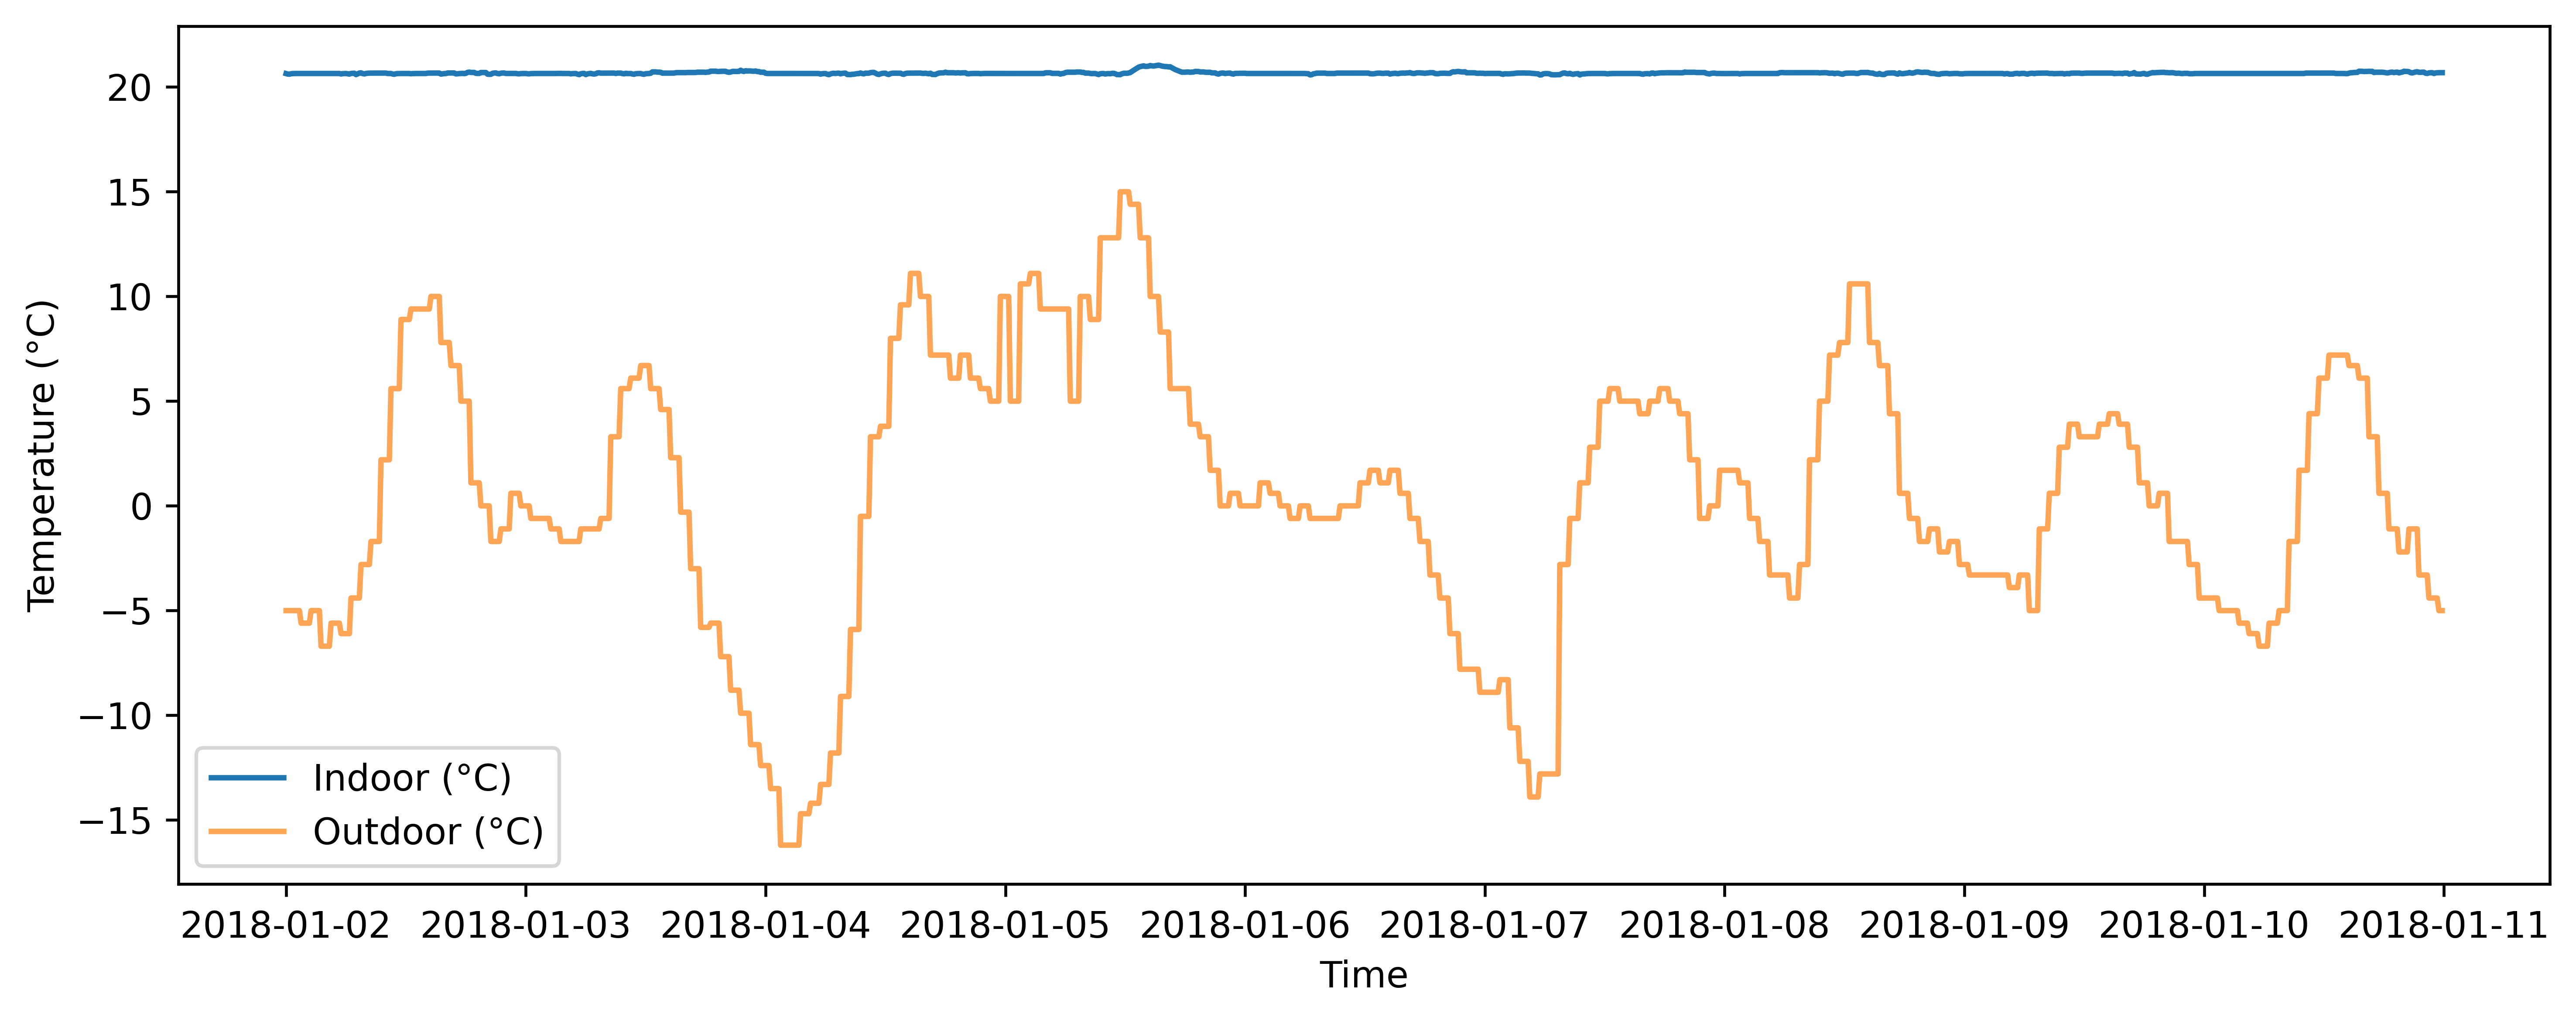

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_10868\132142353.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


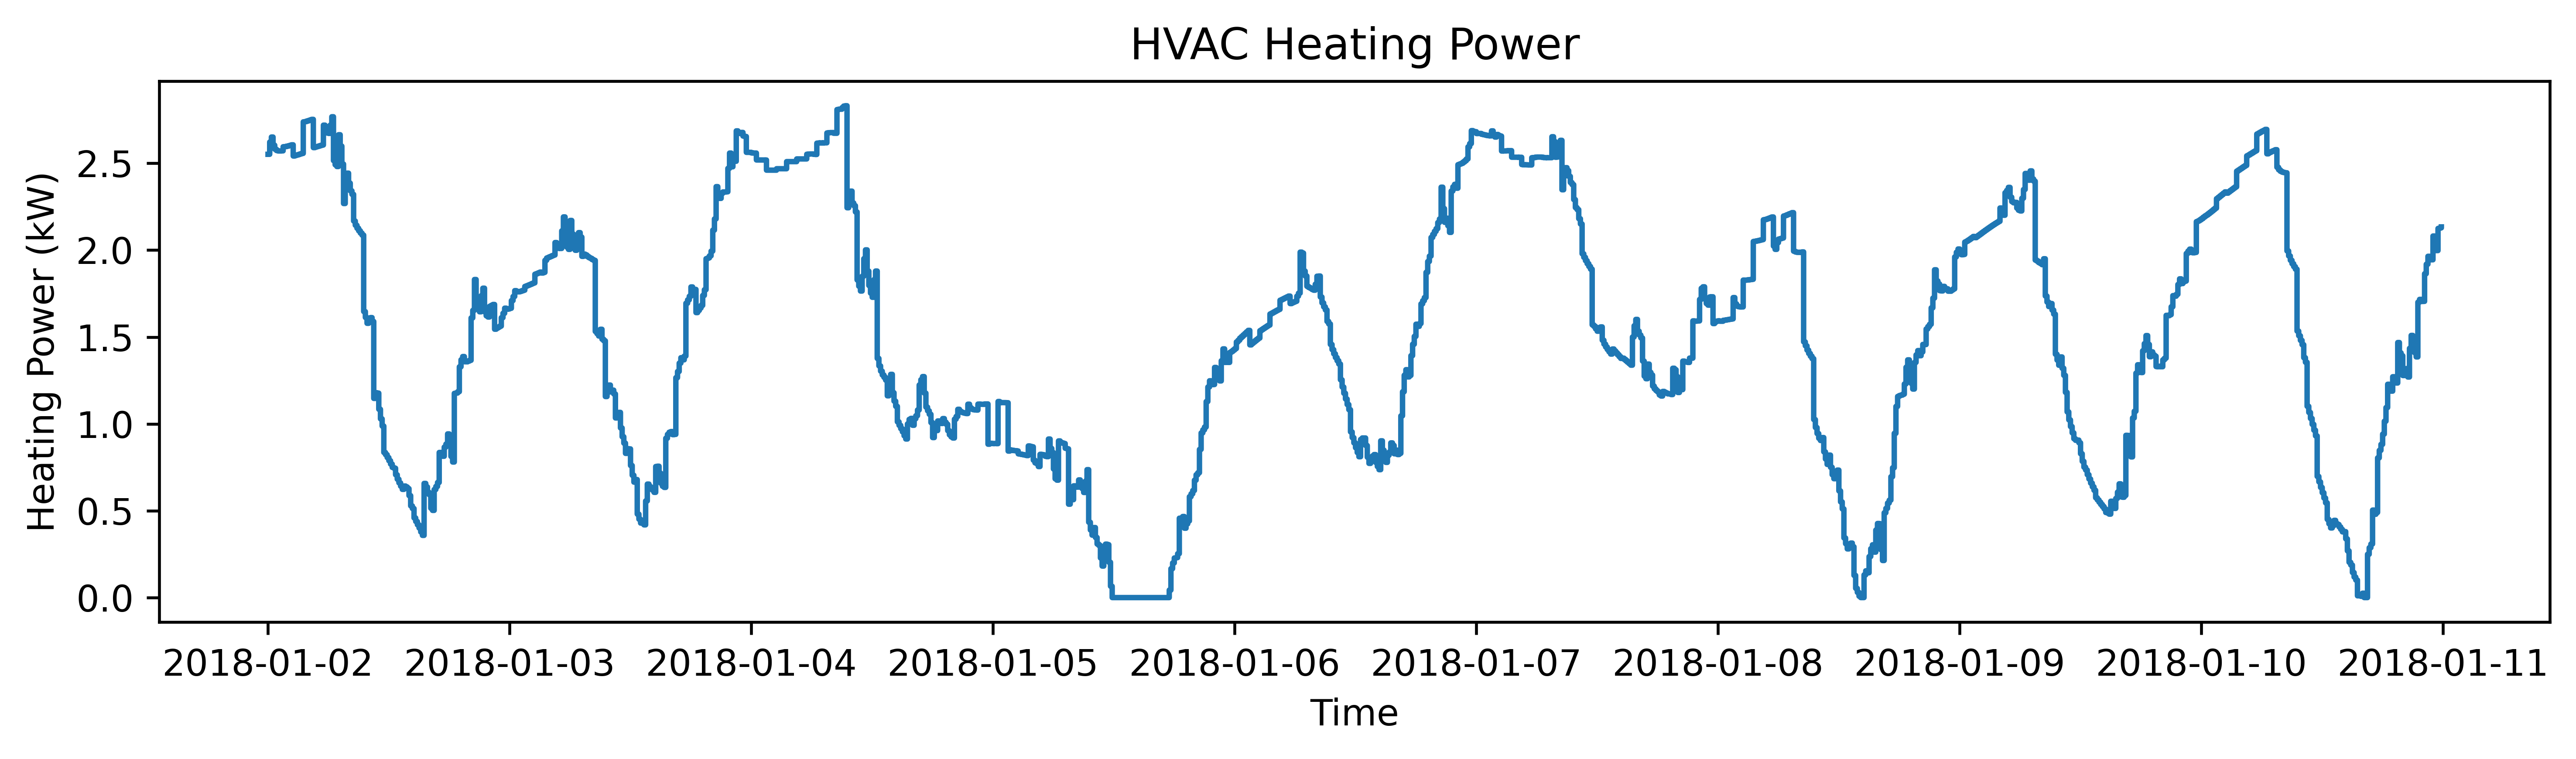

In [30]:
# --------------------------------------------------------------
# 1) Use local sample files that ship with OCHRE
# --------------------------------------------------------------

# Explore what's available
# print("Files under default_input_path:")
# for root, dirs, files in os.walk(default_input_path):
#     for f in files:
#         print(os.path.join(root, f))

# Pick any of the included HPXML + schedule files
hpxml_file = os.path.join(default_input_path, "Input Files", "bldg0112631-up11.xml")
schedule_file = os.path.join(default_input_path, "Input Files", "bldg0112631_schedule.csv")
weather_file = os.path.join(default_input_path, "Weather", "USA_CO_Denver.Intl.AP.725650_TMY3.epw")

print("HPXML:", hpxml_file)
print("Schedule:", schedule_file)
print("Weather:", weather_file)

schedule = pd.read_csv(schedule_file)
weather = pd.read_csv(weather_file)

# --------------------------------------------------------------
# 2) Define Dwelling arguments
# --------------------------------------------------------------
dwelling_args = {
    "start_time": dt.datetime(2018, 1, 1, 0, 0),
    "time_res": dt.timedelta(minutes=10),
    "duration": dt.timedelta(days=10),

    "hpxml_file": hpxml_file,
    "hpxml_schedule_file": schedule_file,
    "weather_file": weather_file,
    "verbosity": 7,
    "metrics_verbosity": 3,}

# --------------------------------------------------------------
# 3) Simulate
# --------------------------------------------------------------
house = Dwelling(**dwelling_args)
df, metrics, hourly = house.simulate()

print("Simulation output:", df.columns[:12])
df.head()

# drop the first day to avoid outliers
df = df.iloc[144:]

# -------------------------------------------------------------------
# 4) Identify key columns
# -------------------------------------------------------------------
# Try to find the right columns by partial name
indoor_temp_col = [c for c in df.columns if "Temperature - Indoor" in c][0]
outdoor_temp_col = [c for c in df.columns if "Temperature - Outdoor" in c or "Outdoor Dry Bulb" in c][0]
heating_power_col = [c for c in df.columns if "HVAC Heating Main Power" in c or "HVAC Heating Power" in c][0]

print("Indoor temp column:", indoor_temp_col)
print("Outdoor temp column:", outdoor_temp_col)
print("Heating power column:", heating_power_col)

T_in  = df[indoor_temp_col].values          # °C
T_out = df[outdoor_temp_col].values         # °C
u     = df[heating_power_col].values        # kW
t_idx = df.index

#%%
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(t_idx, T_in, label="Indoor (°C)")
ax1.plot(t_idx, T_out, label="Outdoor (°C)", alpha=0.7)
ax1.set_ylabel("Temperature (°C)")
ax1.set_xlabel("Time")
ax1.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.step(t_idx, u, where="post")
plt.ylabel("Heating Power (kW)")
plt.xlabel("Time")
plt.title("HVAC Heating Power")
plt.tight_layout()
plt.show()

Visualize indoor and outdoor temperature and respective HVAC heating power.

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_10868\1781048727.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


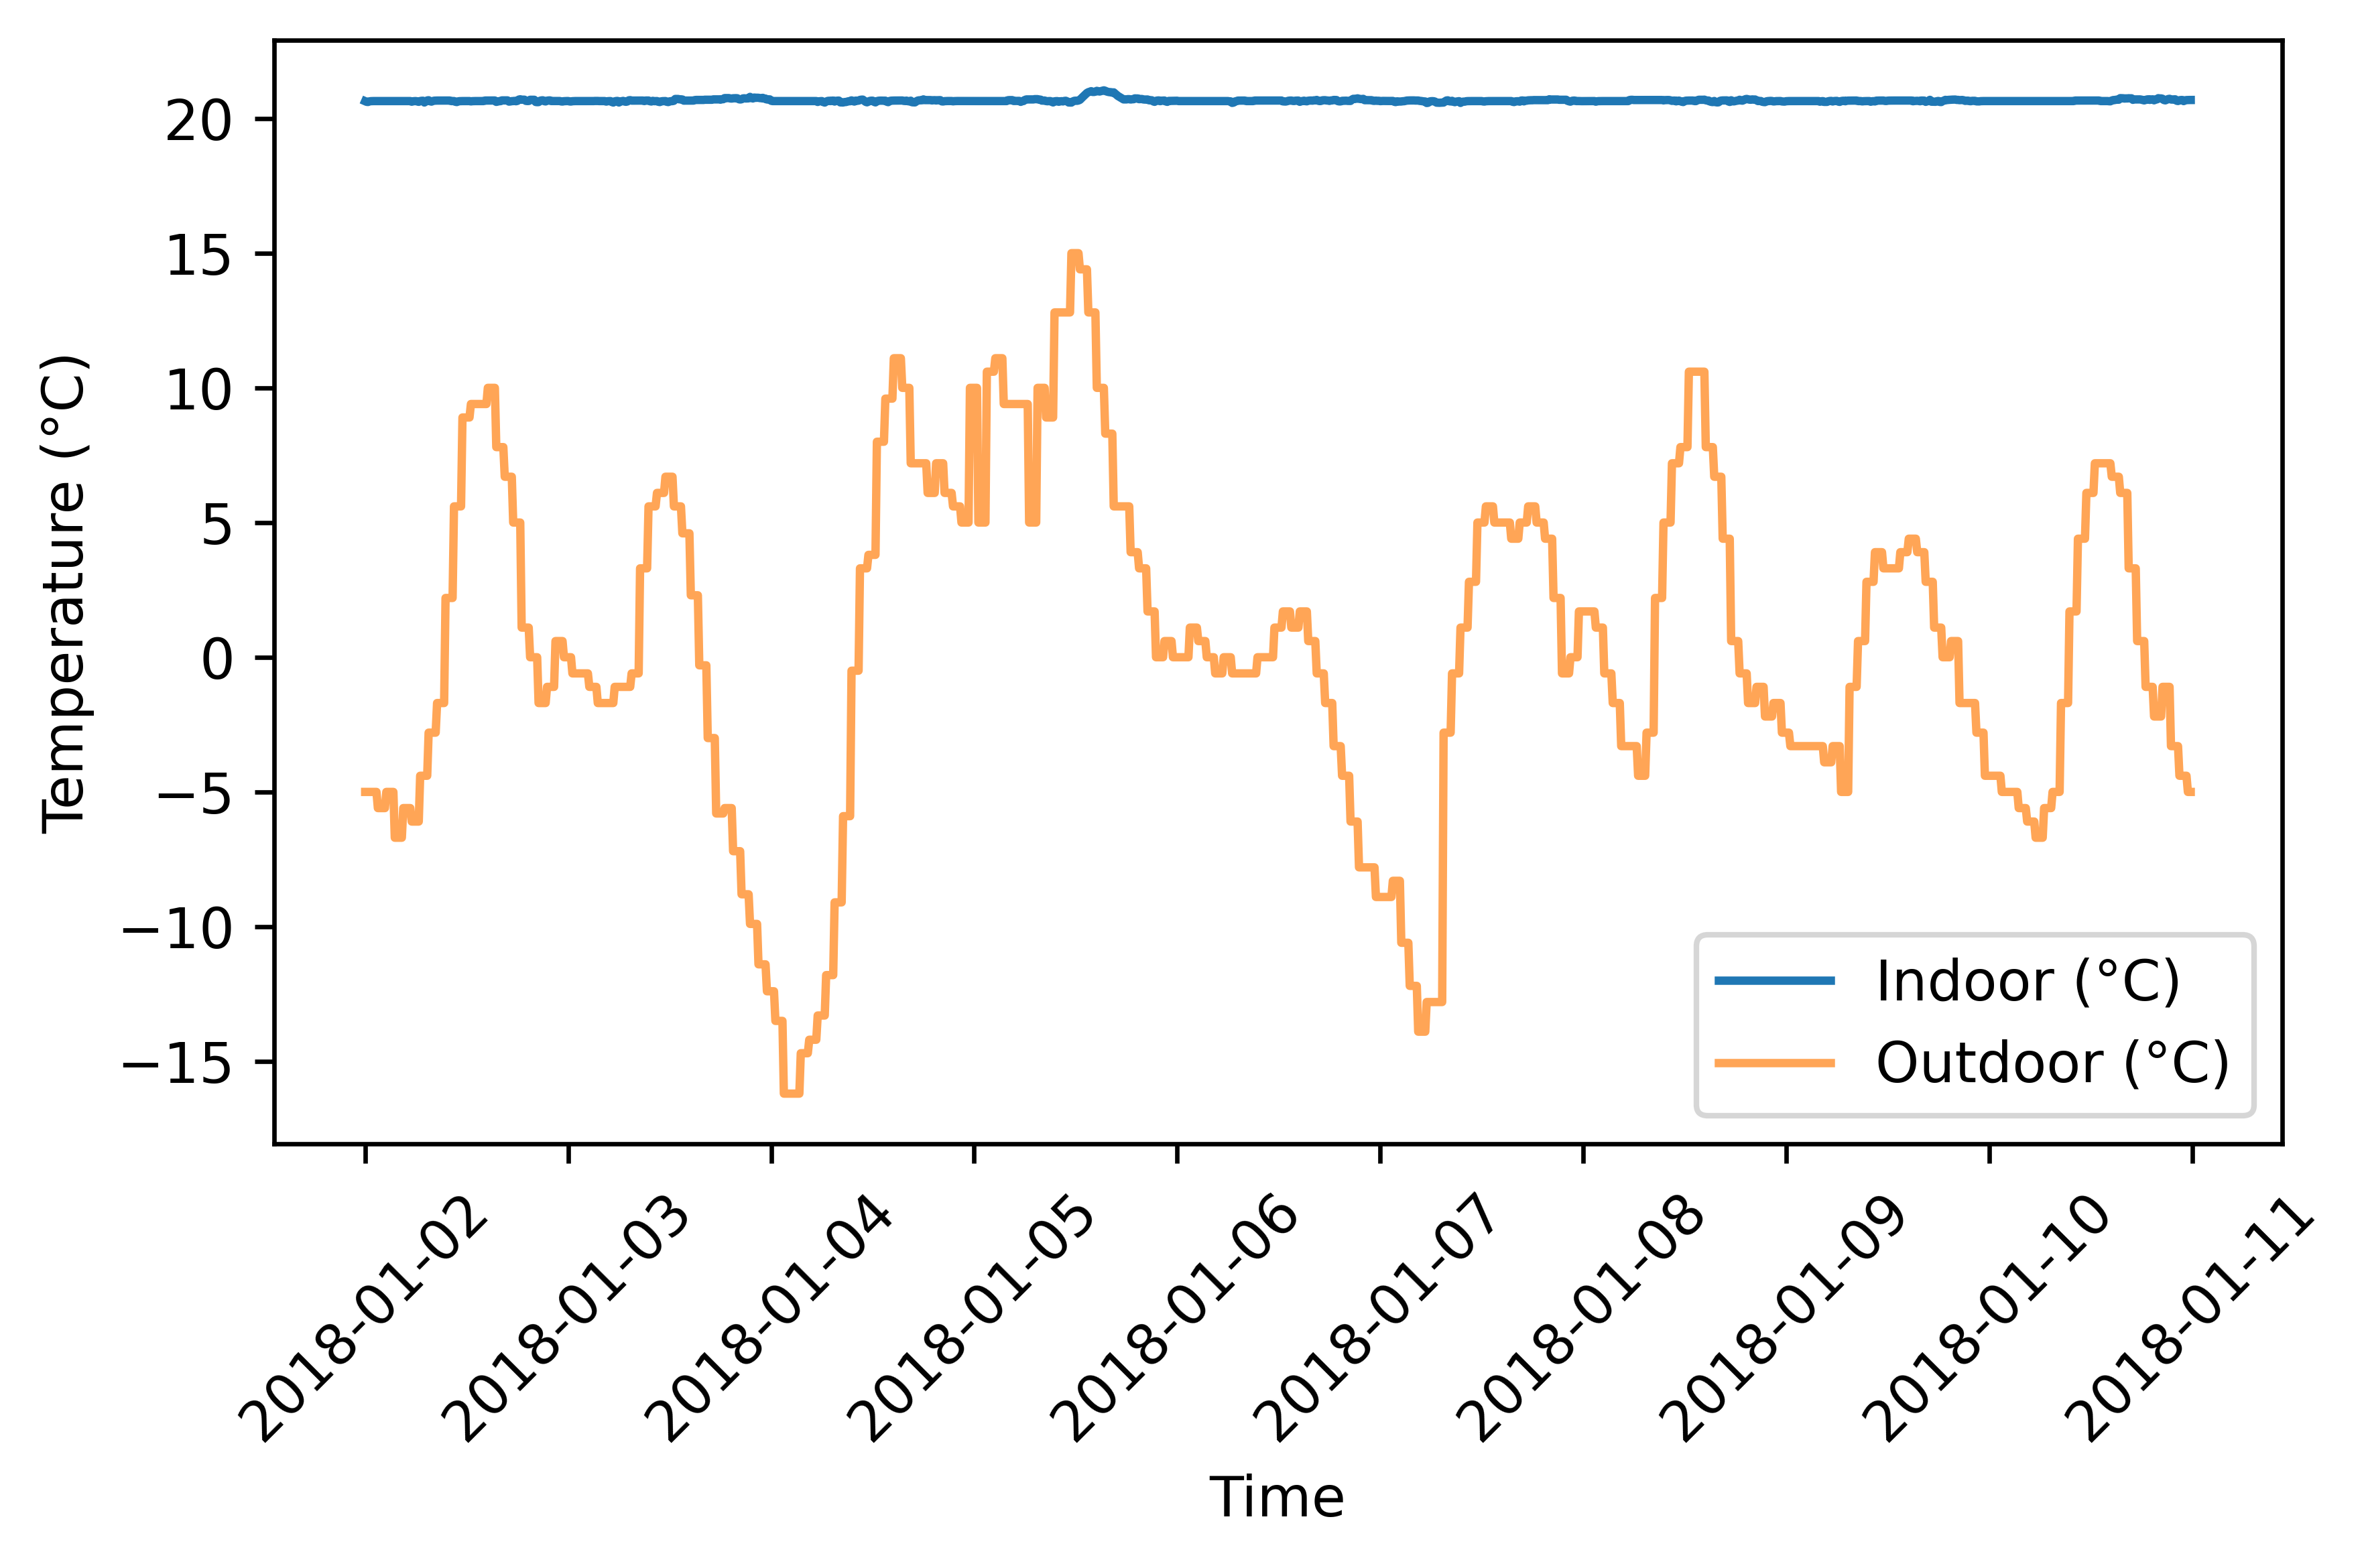

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_10868\1781048727.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


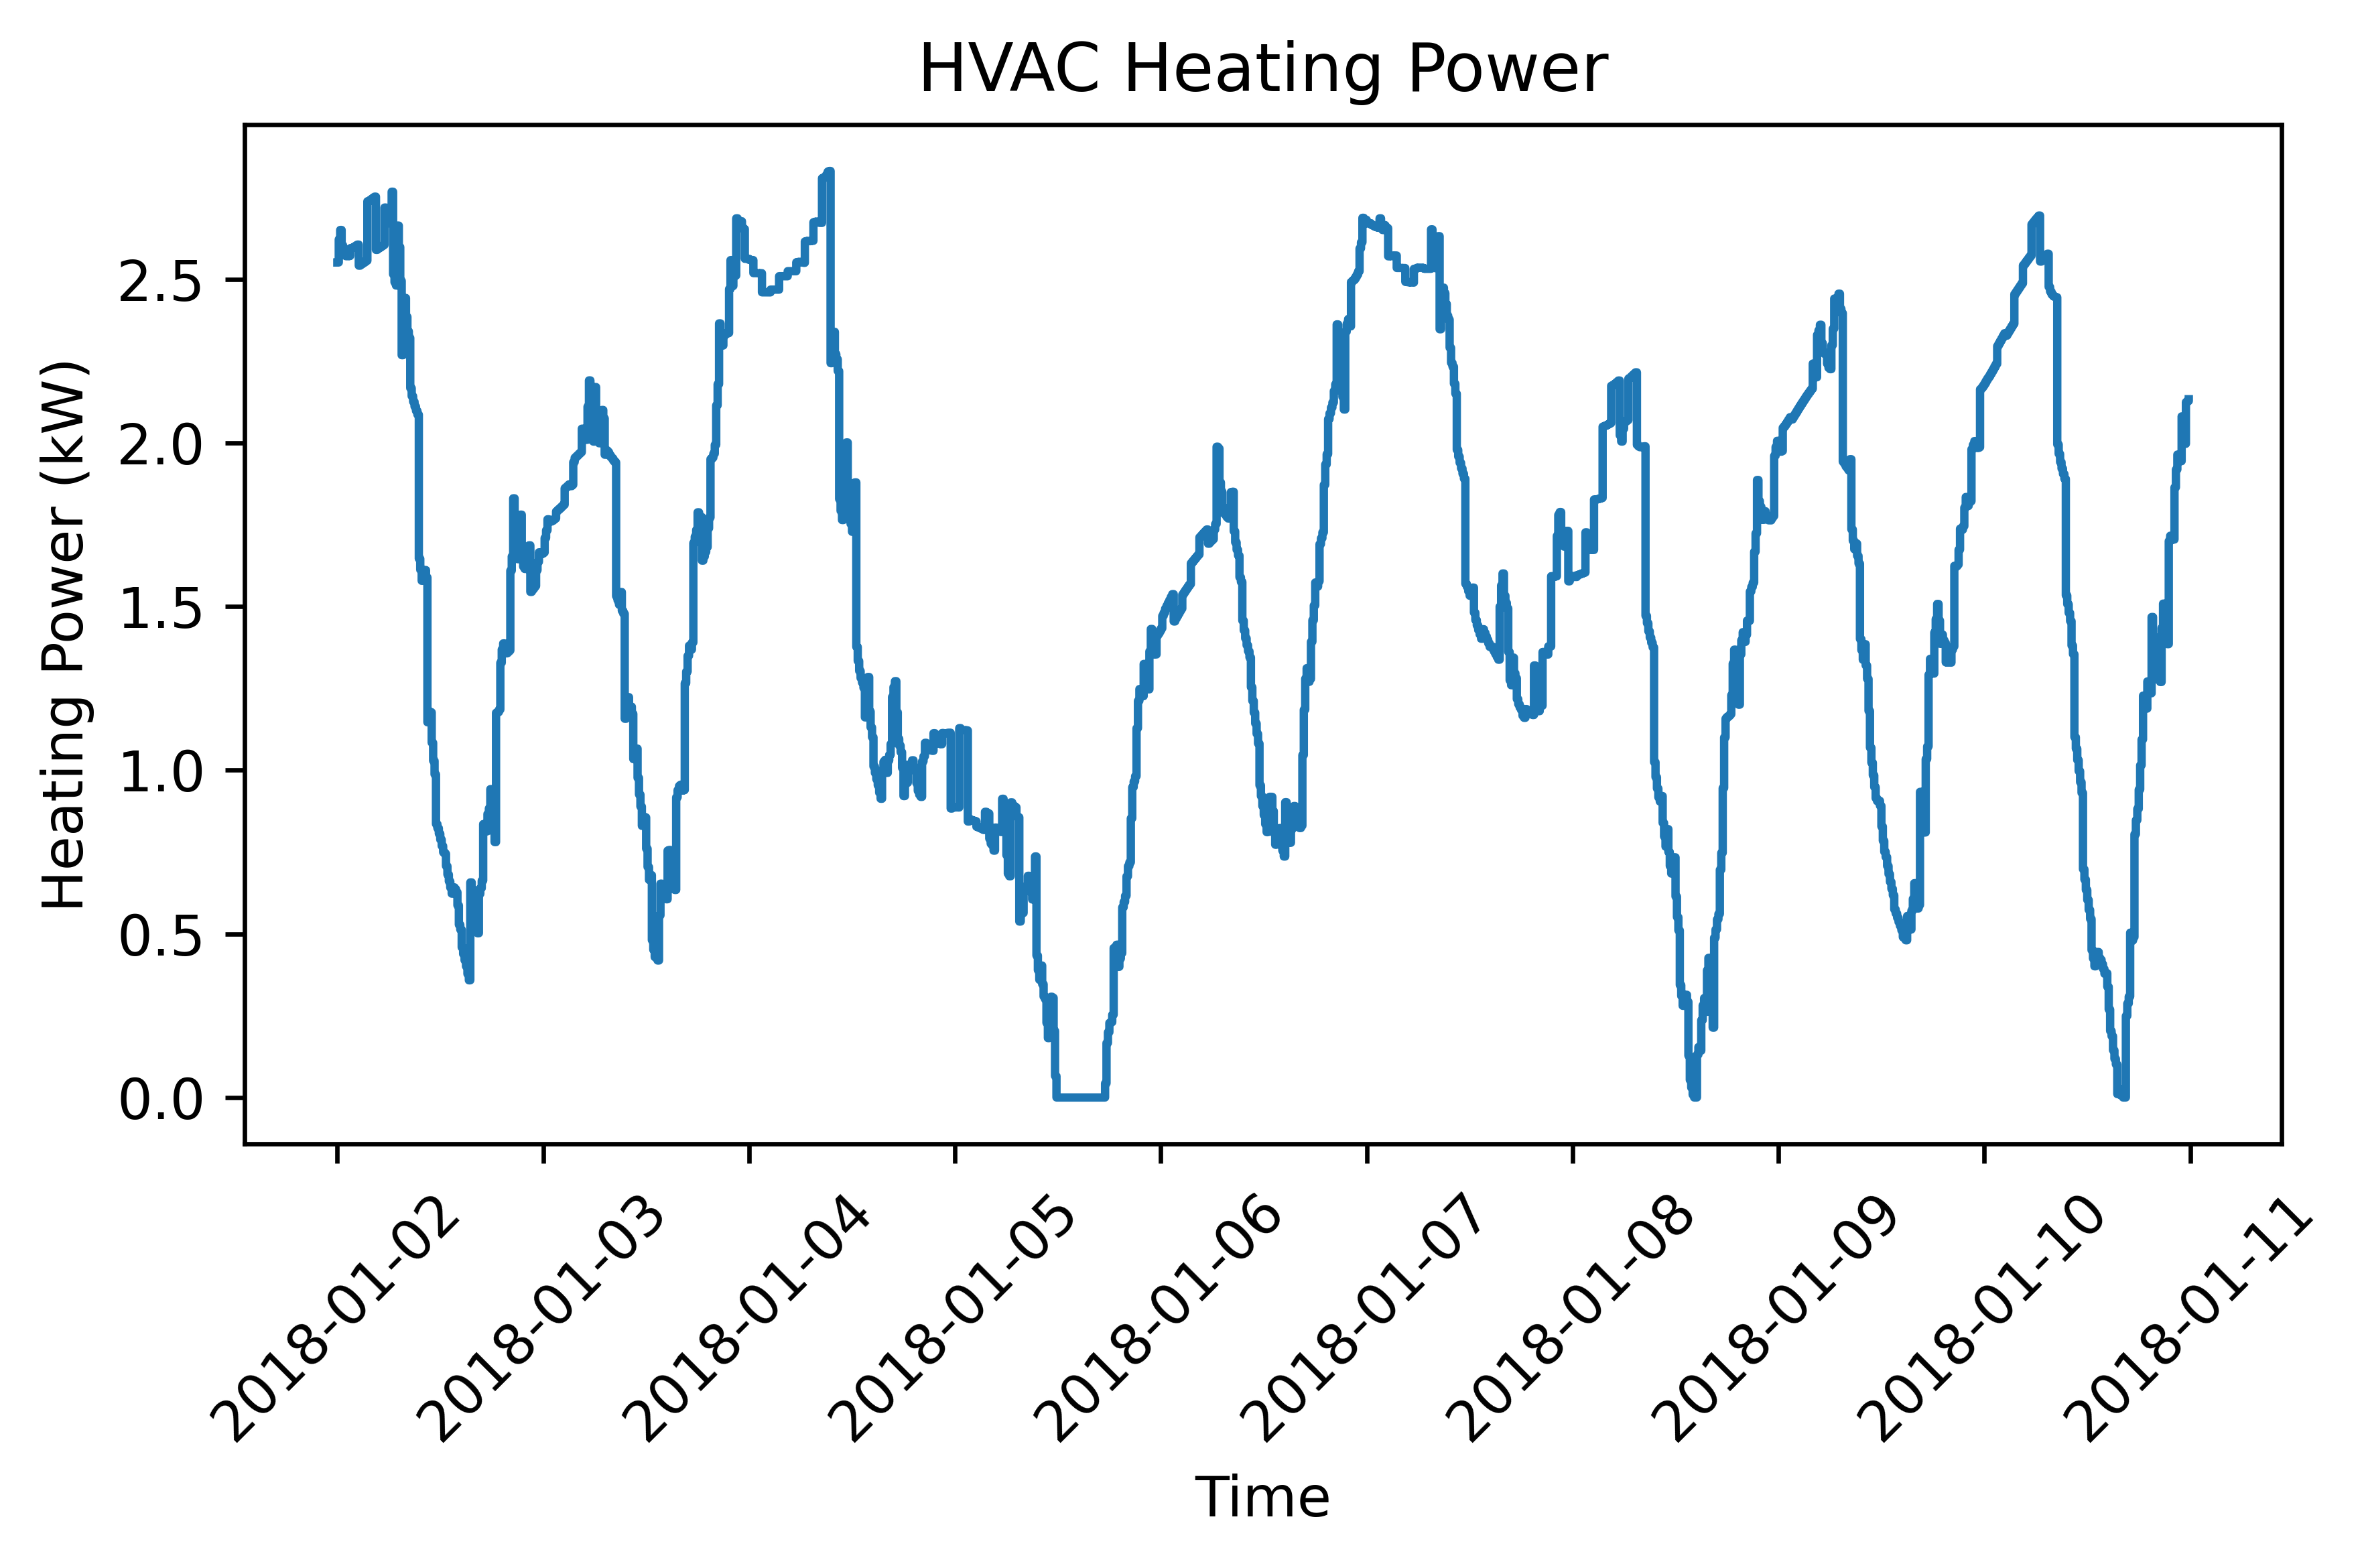

In [31]:
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(t_idx, T_in, label="Indoor (°C)")
ax1.plot(t_idx, T_out, label="Outdoor (°C)", alpha=0.7)
ax1.set_ylabel("Temperature (°C)")
ax1.set_xlabel("Time")
ax1.legend()
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.step(t_idx, u, where="post")
plt.ylabel("Heating Power (kW)")
plt.xlabel("Time")
plt.title("HVAC Heating Power")
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()





---

# **The Thermal RC Model**

We consider a simple $1R-1C$ model to approximate the thermal dynamics of a single-zone dwelling.:

- $R_{\text{th}}$ = thermal resistance (°C/kW)  
- $C_{\text{th}}$ = thermal capacitance (kWh/°C)

The continuous-time energy balance:

**ToDo**: 
- add solar gain
- use estimated parameters from Shuwen's paper

$ C_{\text{th}} \frac{dT}{dt} = \frac{T_\text{out} - T}{R_{\text{th}}} + u $

where:

- $T$ = indoor temperature (°C)  
- $T_\text{out}$ = outdoor temperature (°C)  
- $u$ = heating power (kW), our decision variable.

Define the **time constant**:
$ \tau = R_{\text{th}} C_{\text{th}} $

Then the dynamics become:

$ \frac{dT}{dt} =
\frac{1}{\tau}(T_\text{out} - T)
+ \frac{1}{C_{\text{th}}}u $


---

#### **Discretizing the $RC$ Model**

To discretize the $RC$ model, we use a 10-minute timestep

$\Delta t = 10 \text{ min} = \frac{1}{6} \text{ h}$.

Using forward Euler discretization, we get

$
T_{k+1}
=
T_k
+ \Delta t \frac{1}{\tau}(T_{\text{out},k} - T_k)
+ \Delta t \frac{1}{C_{\text{th}}} u_k,
$

where $k$ is the time step index.

For convenience, we define the **discrete coefficients**:

$
\alpha = \frac{\Delta t}{\tau}, \qquad
\gamma = \frac{\Delta t}{C_{\text{th}}}.
$

The final discrete $RC$ model is:

$
T_{k+1} = T_k + \alpha\bigl(T_{\text{out},k} - T_k\bigr)
+ \gamma u_k$.

This is the model that **MPC will use** internally.

**Question**: interpret the coefficients $\alpha, \gamma$.

---

### Recovering $R$, $C$, $\tau$ from $\alpha$, $\gamma$

Since:

$
\tau = \frac{\Delta t}{\alpha},\qquad
C_{\text{th}} = \frac{\Delta t}{\gamma},\qquad
R_{\text{th}} = \frac{\tau}{C_{\text{th}}}
$

we can get physical values from our chosen discrete parameters.

Example values used in this notebook:

- $\alpha = 0.0208$
- $\gamma = 0.16$

Then (for $\Delta t = 10$ min):

- $C_{\text{th}} \approx 6.25\ \text{kWh/°C}$  
- $\tau \approx 8\ \text{h}$  
- $R_{\text{th}} \approx 1.28\ \text{°C/kW}$

These correspond to a typical **small/medium dwelling**.

**ToDo: Validate numbers using Shuwen's paper and Tutorial 1/2**
---


# MPC Optimization Problem Formulation

Next, we formulate the optimization problem that is part of the MPC controller.

Our goal is to minimize total **electricity cost** (assuming heating is an electric load), while ensuring indoor temperature is maintained inside a *comfort band*. The technical limitations of the HVAC system present additional constraints.
We will examine two cases: *(i)* all constraints are hard, *(ii)* thermal violations are encoded as soft constraints.


### Hard Constraints

We want to maintain the indoor temperature inside a comfort band
\begin{aligned}
T_{\min} \leq T_k \leq T_{\max},
\end{aligned}
where $T_{\min}, T_{\max}$ are provided by the user.
We further want to minimize the total **electricity cost** over a horizon of $N$ steps, given by
\begin{aligned}
\sum_{k=0}^{N-1} p_k\,u_k\,\Delta_t,
\end{aligned}
where $p_k$ denotes the $k$th step electricity prices.

The MPC problem that optimizes heating operation to minimize electricity costs is given by

\begin{aligned}
\texttt{MPC}:
\min_{T,u}\quad &
\sum_{k=0}^{N-1}
p_k u_k \Delta,
\\[6pt]
\text{s.t.}\quad
&
T_{k+1} = T_k
+ \alpha (T_{\text{out}, k} - T_k)
+ \gamma u_k,
\\
&
T_{\min} \le T_{k+1} \le T_{\max},
\\
&
0 \le u_k \le u_{\max}.
\end{aligned}
This is a **linear programming (LP)** problem that is easily solved with off-the-shelf solvers.


### Soft Constraints

Adding hard constraints on temperature may lead to infeasible formulations.
In this iteration, we allow *soft violations* by introcuding non-negative slack variables $s_k^-, s_k^+$ and modifying the constraints as

\begin{aligned}
& T_{\min} - {s_k^-} 
\leq T_k \leq T_{\max} + {s_k^+}, 
\\
& {s_k^+} \geq 0,\quad {s_k^-} \geq 0.
\end{aligned}

The upward slack ${s_k^+}$ represents the allowed violations of the upper bound. 
Similarly, ${s_k^-}$ represents the allowed violations of the lower bound. 
We penalize these thermal comfort violations using a quadratic penalty

\begin{aligned}
{\lambda_s \sum_k \left((s_k^+)^2 + (s_k^-)^2\right)},
\end{aligned}

where $\lambda_s$ is a user-defined hyperparameter (or weight).
The soft-constrained MPC problem is given by

\begin{aligned}
\texttt{softMPC}:
\min_{T,u,s^+,s^-}\quad &
\sum_{k=0}^{N-1}
\left(
p_k u_k \Delta t
+ \color{blue}{\lambda_s\bigl[(s_k^+)^2+(s_k^-)^2\bigr]}
\right),
\\[6pt]
\text{s.t.}\quad
&
T_{k+1} = T_k
+ \alpha (T_{\text{out}, k} - T_k)
+ \gamma u_k,
\\
&
T_{\min} - {s_k^-} \le T_{k+1} \le T_{\max} + {s_k^+},
\\
&
0 \le u_k \le u_{\max}.
\end{aligned}

This is a **convex quadratic program**, easily solved with off-the-shelf solvers.
When $\lambda_s → \infty $, the solution of $\texttt{softMPC}$ converges to the one of $\texttt{MPC}$.

In the following cell we construct two functions that take as input problem parameters and return the solutions and objective value for $\texttt{MPC}$ and $\texttt{softMPC}$.

In [32]:
def solve_mpc_rc(T0, T_out, price, alpha, gamma, T_min, T_max, u_min, u_max,
    dt_minutes=10, verbose = 0):
    
    T_out = np.asarray(T_out)
    price = np.asarray(price)
    N = len(T_out)
    dt_h = dt_minutes / 60.0

    T = cp.Variable(N + 1)
    u = cp.Variable(N)
    # s_plus = cp.Variable(N, nonneg=True)
    # s_minus = cp.Variable(N, nonneg=True)

    constraints = [T[0] == T0]

    for k in range(N):
        constraints += [
            T[k+1] == T[k] + alpha * (T_out[k] - T[k]) + gamma * u[k],
            u_min <= u[k],
            u[k] <= u_max,
            T_min <= T[k+1],
            T[k+1] <= T_max,
            ]

    energy_cost = cp.sum(cp.multiply(price, u)) * dt_h
    cost = energy_cost

    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()

    if verbose != 0:
        print("Status:", prob.status)
        print("Optimal cost:", prob.value)
    
    return T.value, u.value, prob

def solve_mpc_rc_soft(T0, T_out, price, alpha, gamma, T_min, T_max, u_min, u_max,
    dt_minutes=10, lambda_slack = 10, verbose = 0):
    
    T_out = np.asarray(T_out)
    price = np.asarray(price)
    N = len(T_out)
    dt_h = dt_minutes / 60.0

    T = cp.Variable(N + 1)
    u = cp.Variable(N)
    s_plus = cp.Variable(N, nonneg=True)
    s_minus = cp.Variable(N, nonneg=True)

    constraints = [T[0] == T0]

    for k in range(N):
        constraints += [
            T[k+1] == T[k] + alpha * (T_out[k] - T[k]) + gamma * u[k],
            u_min <= u[k],
            u[k] <= u_max,
            T_min - s_minus[k] <= T[k+1],
            T[k+1] <= T_max + s_plus[k],
            ]

    comfort_penalty = lambda_slack * (cp.sum_squares(s_plus) + cp.sum_squares(s_minus))
    energy_cost = cp.sum(cp.multiply(price, u)) * dt_h

    cost = energy_cost + comfort_penalty
    
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()

    if verbose != 0:
        print("Status:", prob.status)
        print("Optimal cost:", prob.value)
    
    return T.value, u.value, s_plus.value, s_minus.value, prob

# Effect of price tarrifs

We use $\texttt{MPC}$ to examine what is the effect of price tarrifs on HVAC control actions. In the following cell, we solve the single-day optimization problem considering *(i)* fixed prices throughout the day and *(ii)* time-of-use price tarrif. We solve $\texttt{MPC}$ twice, varying the price vector, and visualize the control actions.

R_th = 7.69 °C/kW, C_th = 1.04 kWh/°C, tau = 8.0 h
Status: optimal
Optimal cost: 11.796989875179992
Status: optimal
Optimal cost: 8.586650224010928


C:\Users\ucbva19\AppData\Local\Temp\ipykernel_10868\2904309651.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


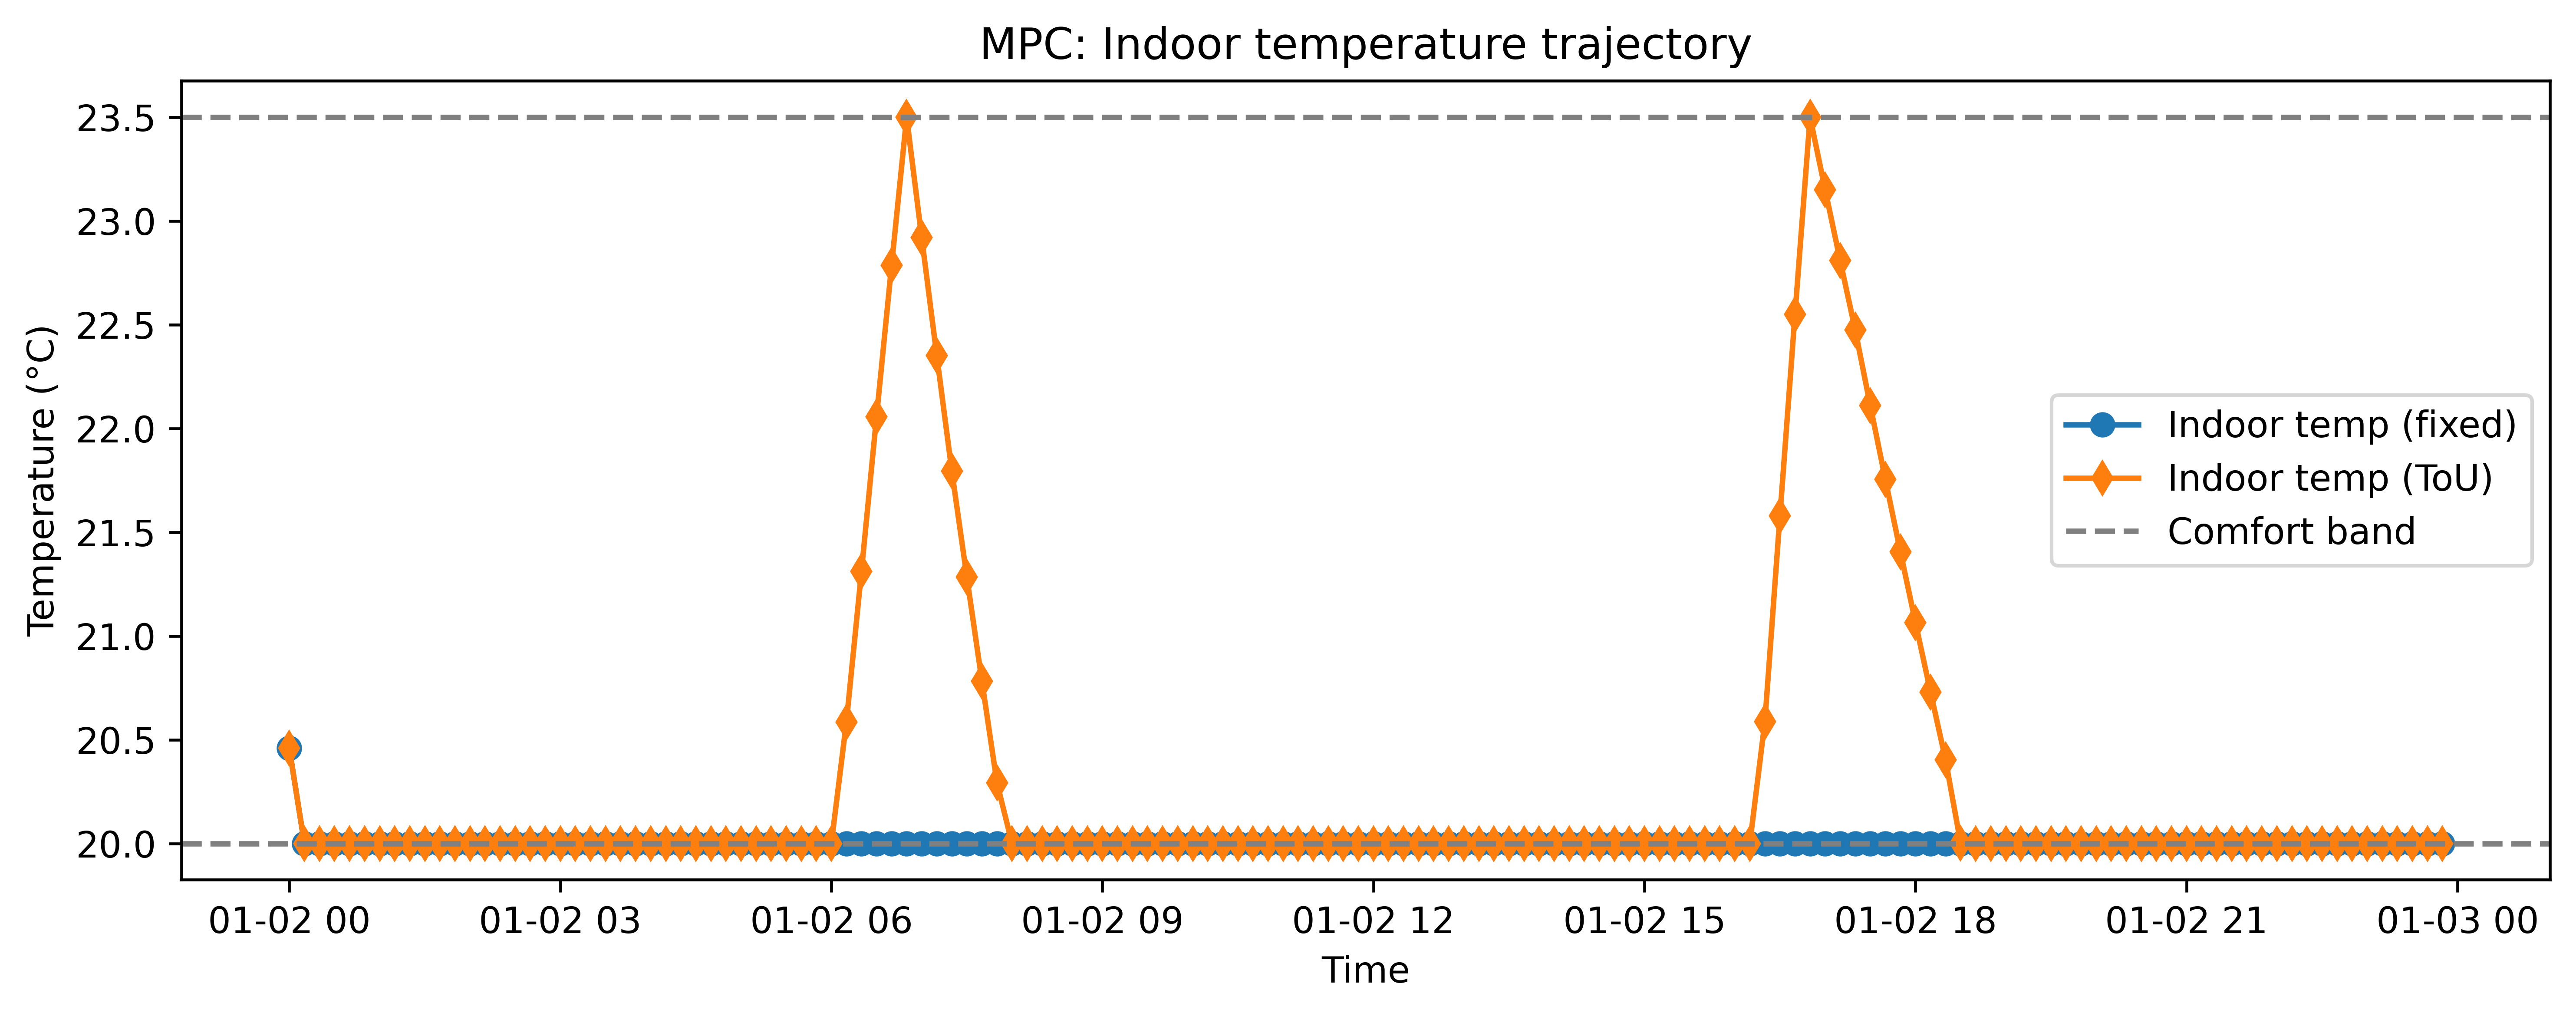

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_10868\2904309651.py:84: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


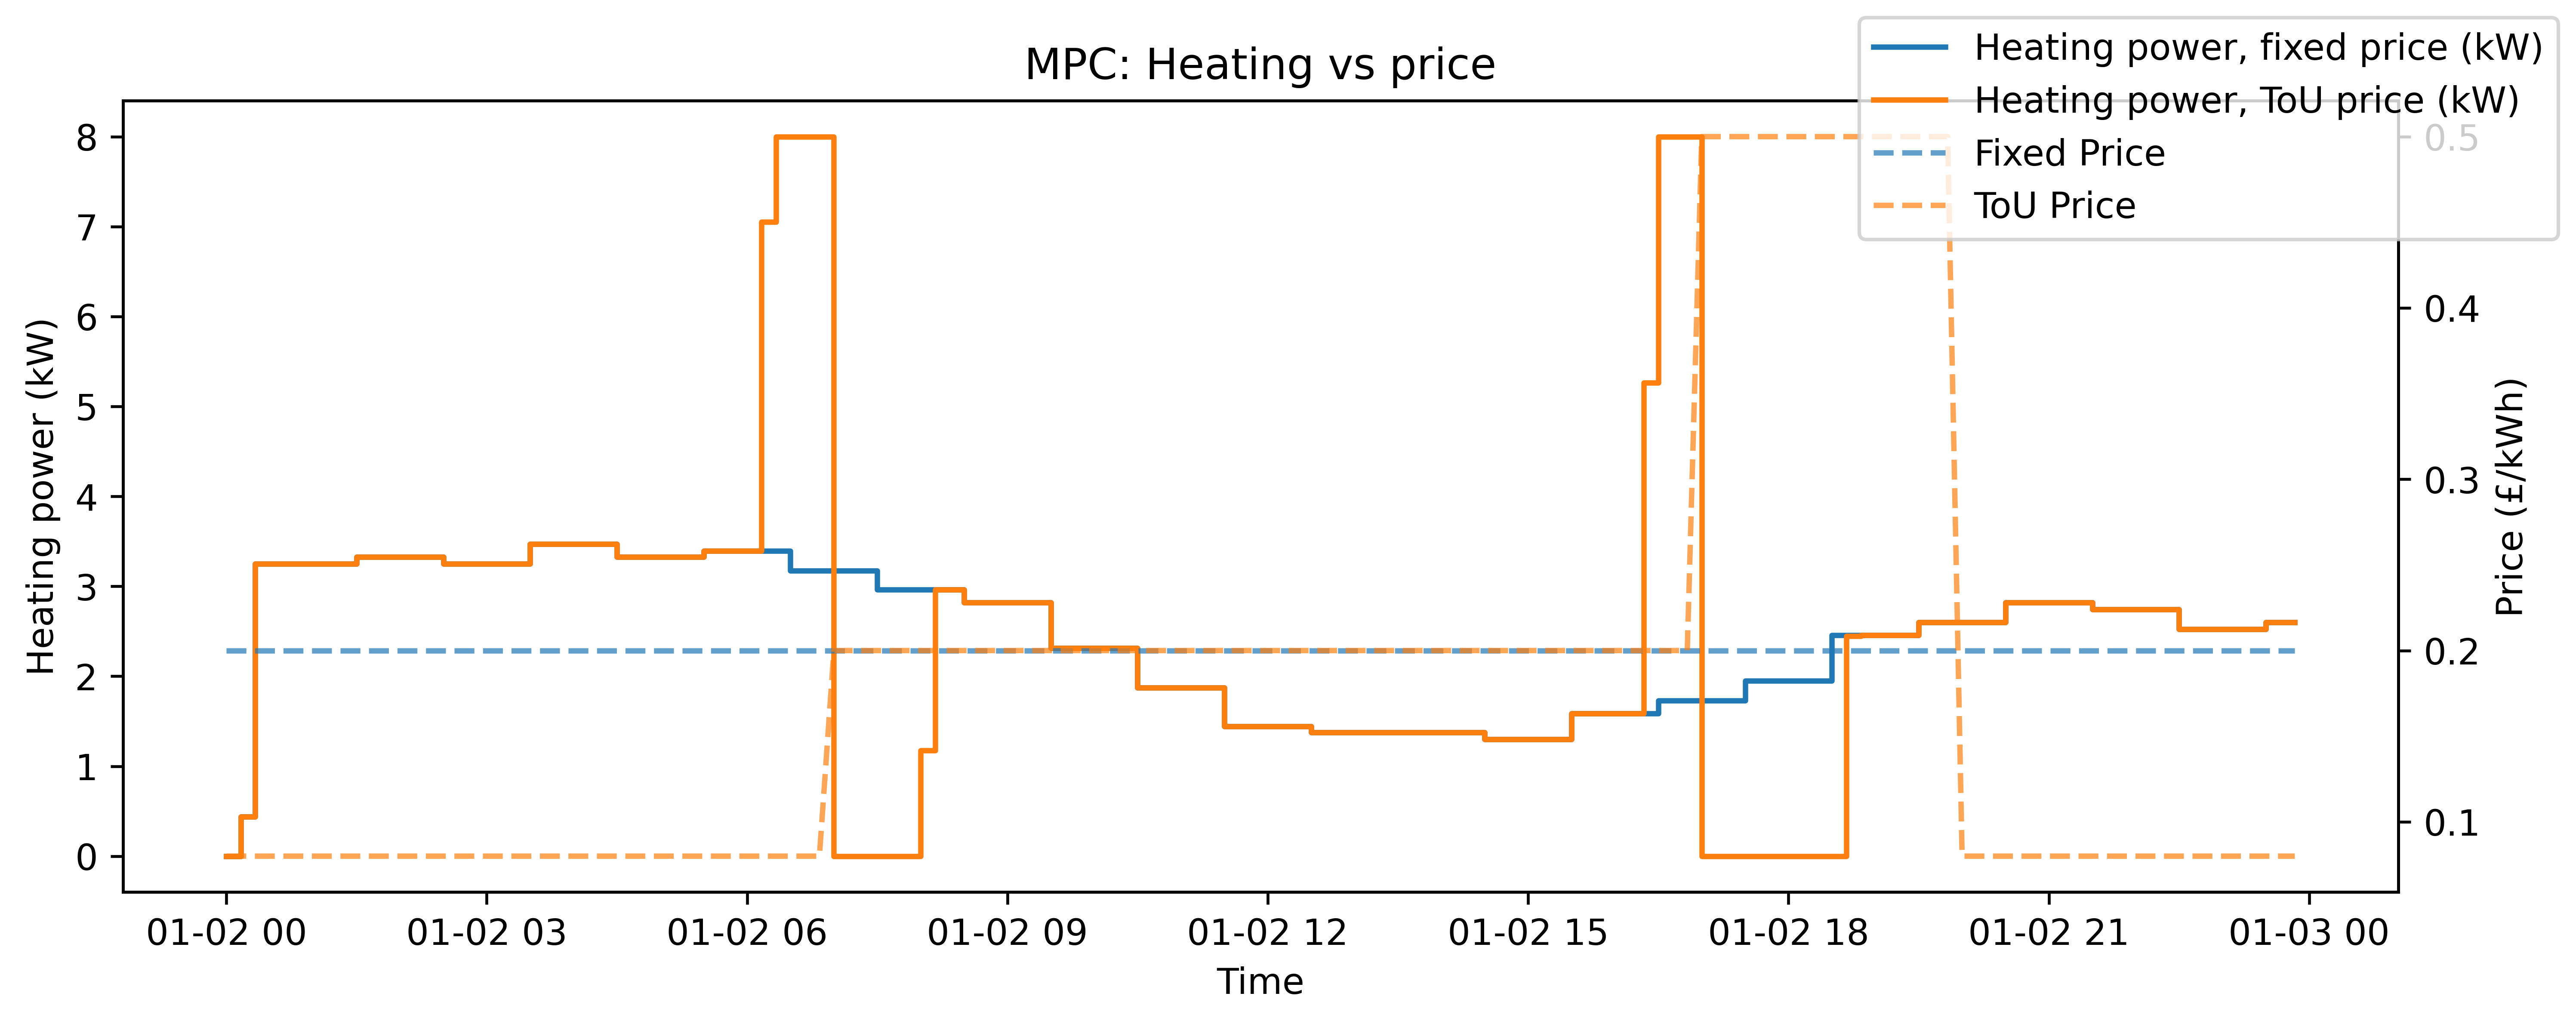

In [34]:
dt_minutes = 10
dt_hours = dt_minutes / 60

# Pick 1 day from the OCHRE simulation for our MPC horizon
start = 24 * 6        # e.g. skip the first day to avoid warm-up; adjust as needed
N_steps = 24 * 6      # 24 hours * 6 steps/hour = 144 steps at 10-min

T_out_MPC = T_out[start:start+N_steps]
time_index = t_idx[start:start+N_steps]

# Comfort band and bounds
T_min = 20.0
T_max = 23.5
u_min = 0.0
u_max = 8.0   # kW, adjust as needed

T0 = 21.0     # initial indoor temp for MPC model


# -------------------------------------------------------------------
# 2) Horizon and price profile
# -------------------------------------------------------------------
N_hours = 24
steps_per_hour = int(60 / dt_minutes)
N = N_hours * steps_per_hour

time_index = pd.date_range("2018-01-02", periods=N, freq=f"{dt_minutes}min")  # example date

# Time-of-use and fixed prices
tou_price = build_price_profile(time_index)
fxd_price =  0.20*np.ones(N_steps)

#%%

# -------------------------------------------------------------------
# 3) MPC problem (single-day open-loop optimization)
# -------------------------------------------------------------------
# --- RC model parameters ---
alpha = 0.0208   # envelope leak (10-min step)
gamma = 0.16     # heating gain (°C per kW per 10-min)
dt_minutes = 10
dt_hours = dt_minutes / 60

R_th, C_th, tau = rc_from_alpha_gamma(alpha, gamma)
print(f"R_th = {R_th:.2f} °C/kW, C_th = {C_th:.2f} kWh/°C, tau = {tau:.1f} h")

# solve with fixed price
T_fxd, u_fxd, prob_fxd = solve_mpc_rc(T0, T_out[:N_steps], fxd_price, alpha, gamma, T_min, T_max, 
                                      u_min, u_max, dt_minutes=10, verbose = 1)


# solve with ToU price
T_tou, u_tou, prob_tou = solve_mpc_rc(T0, T_out[:N_steps], tou_price, alpha, gamma, T_min, T_max, 
                                      u_min, u_max, dt_minutes=10, verbose = 1)

#%%
plt.figure(figsize=(10,4))
plt.plot(time_index, T_fxd[1:], '-o', label="Indoor temp (fixed)")
plt.plot(time_index, T_tou[1:], '-d', label="Indoor temp (ToU)")
plt.axhline(T_min, color="grey", linestyle="--", label="Comfort band")
plt.axhline(T_max, color="grey", linestyle="--")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time")
plt.legend()
plt.title("MPC: Indoor temperature trajectory")
plt.tight_layout()
plt.show()


# Control and price
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.step(time_index, u_fxd, where="post", label="Heating power, fixed price (kW)")
ax1.step(time_index, u_tou, where="post", label="Heating power, ToU price (kW)")
ax1.set_ylabel("Heating power (kW)")
ax1.set_xlabel("Time")

ax2 = ax1.twinx()
ax2.plot(time_index, fxd_price, "--", alpha=0.7, label="Fixed Price")
ax2.plot(time_index, tou_price, "--", alpha=0.7, label="ToU Price")
ax2.set_ylabel("Price (£/kWh)")

fig.legend(loc="upper right")
plt.title("MPC: Heating vs price")
plt.tight_layout()
plt.show()

### Analysis

**ToDo**: 
- provide questions for further analysis
- wait students to write code
- provide answer (complete the cell

**Ideas**: how does temperature vary; how does external temperature effect results; vary prices, etc.

### Ιnfeasibilities

Consider an extreme case now where temperatures become extremely negative. This example is unrealistic but aims to illustrate the potential problem with hard constraints. In the following we compare the solutions to $\texttt{MPC}$ and $\texttt{softMPC}$ under extremely negative temperatures. What do you observe (set ```verbose==1```)?

In [35]:
#%% What happens in extreme case

# MPC with hard constraints
print('Solving MPC')
_, _, _= solve_mpc_rc(T0, -10*T_out[:N_steps], tou_price, alpha, gamma, T_min, T_max, 
                                      u_min, u_max, dt_minutes=10, verbose = 1)

# MPC with soft constraints and slacks
print('Solving softMPC')
_, _, _, _, _= solve_mpc_rc_soft(T0, -10*T_out[:N_steps], tou_price, alpha, gamma, T_min, T_max, 
                                      u_min, u_max, dt_minutes=10, lambda_slack = 10, verbose = 1)


Solving MPC
Status: infeasible
Optimal cost: inf
Solving softMPC
Status: optimal
Optimal cost: 177029.21605256147


*Why does this happen?*

Let's revisit the previous example but using the $\texttt{softMPC}$ formulation.

**ToDo**: examine what happens when we vary $\lambda$; add interactive bar which students move arround then observe the new plots.

Status: optimal
Optimal cost: 7.279929218246616


C:\Users\ucbva19\AppData\Local\Temp\ipykernel_10868\3181432347.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


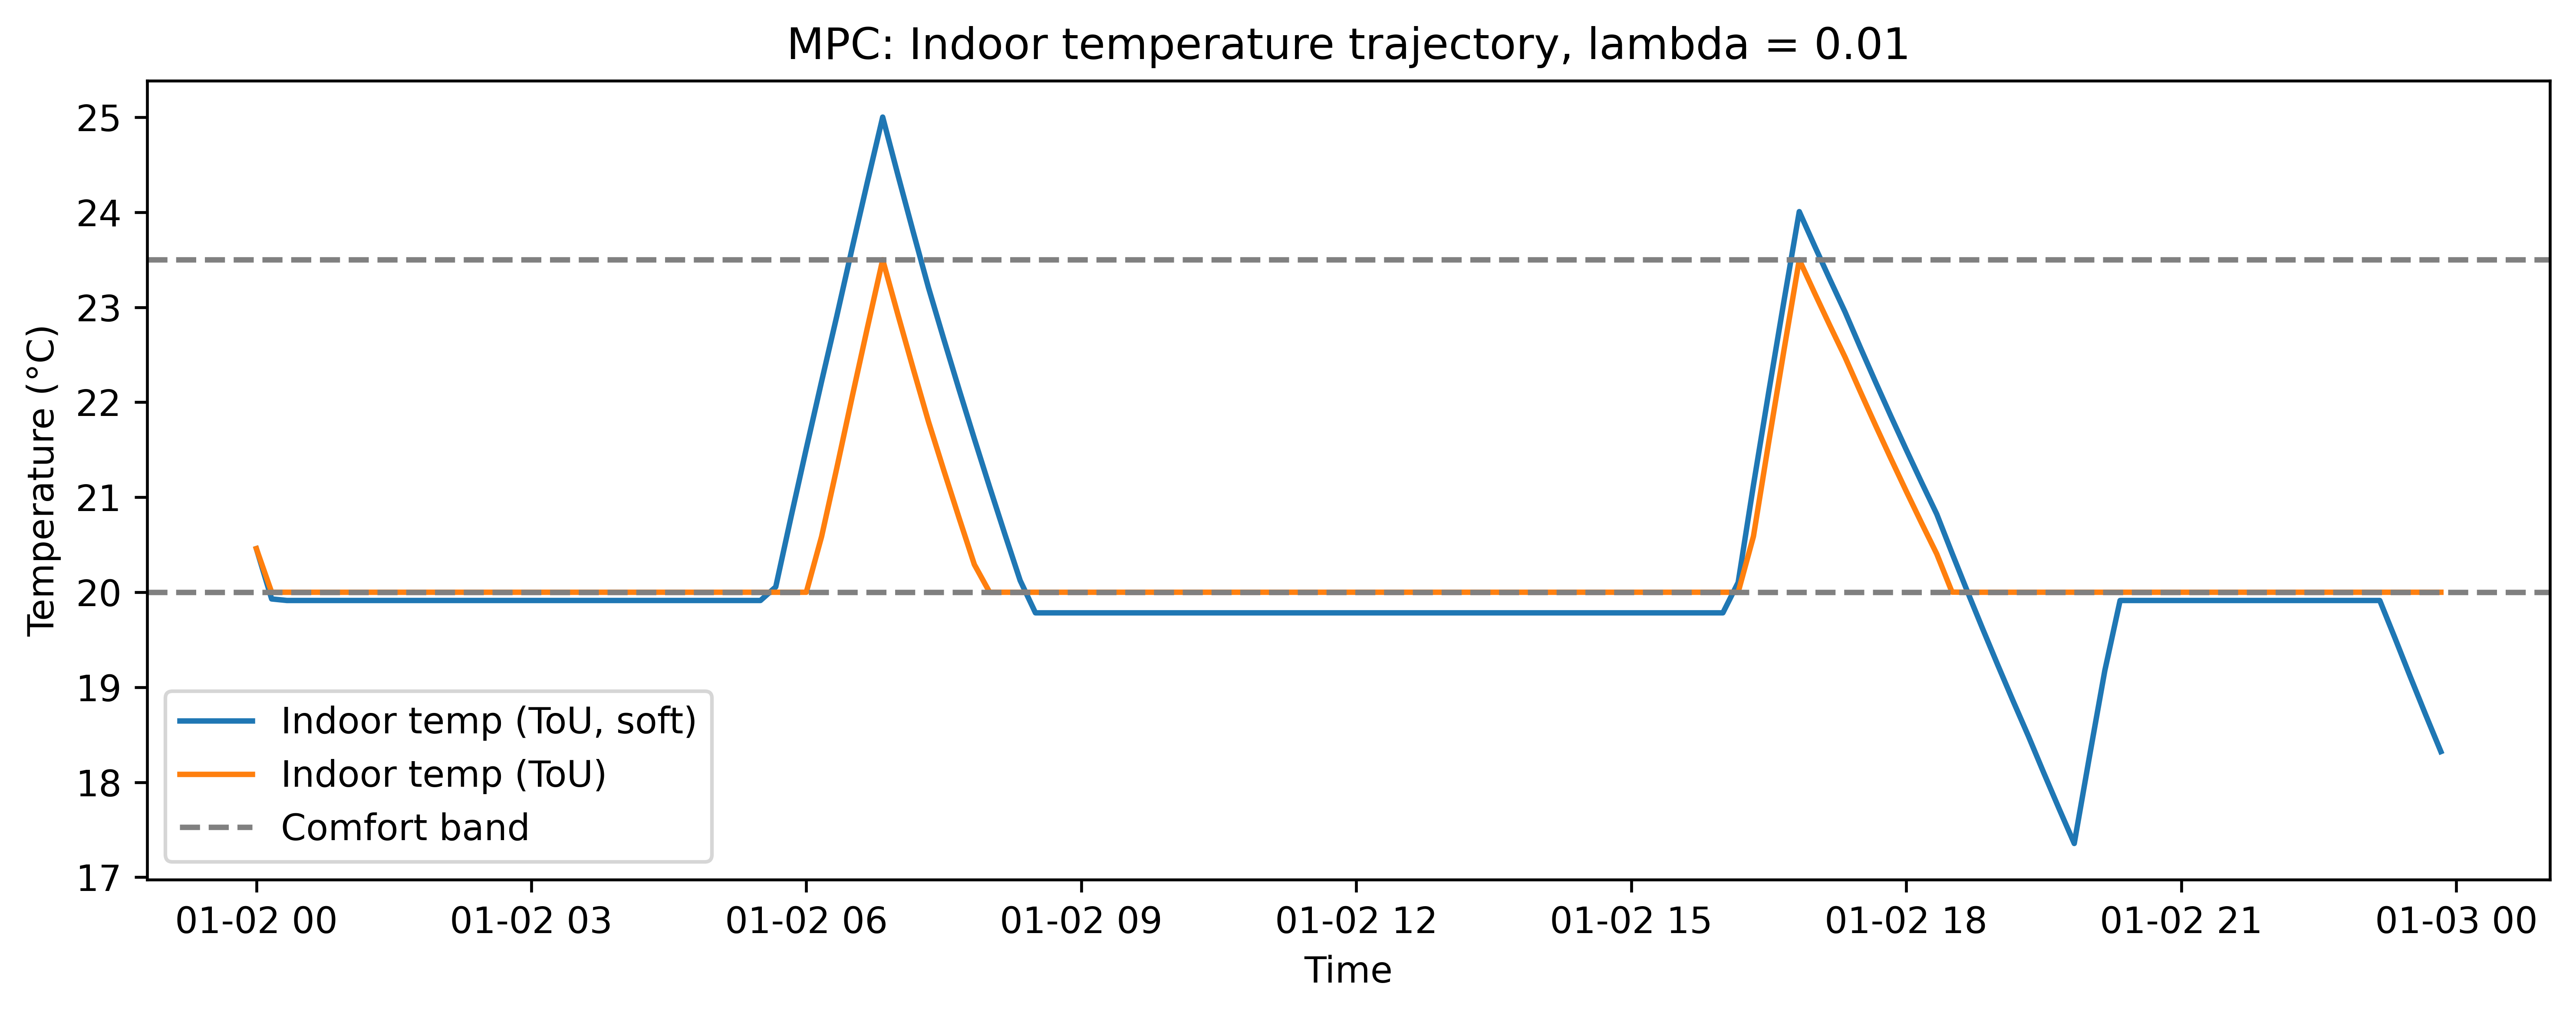

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_10868\3181432347.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


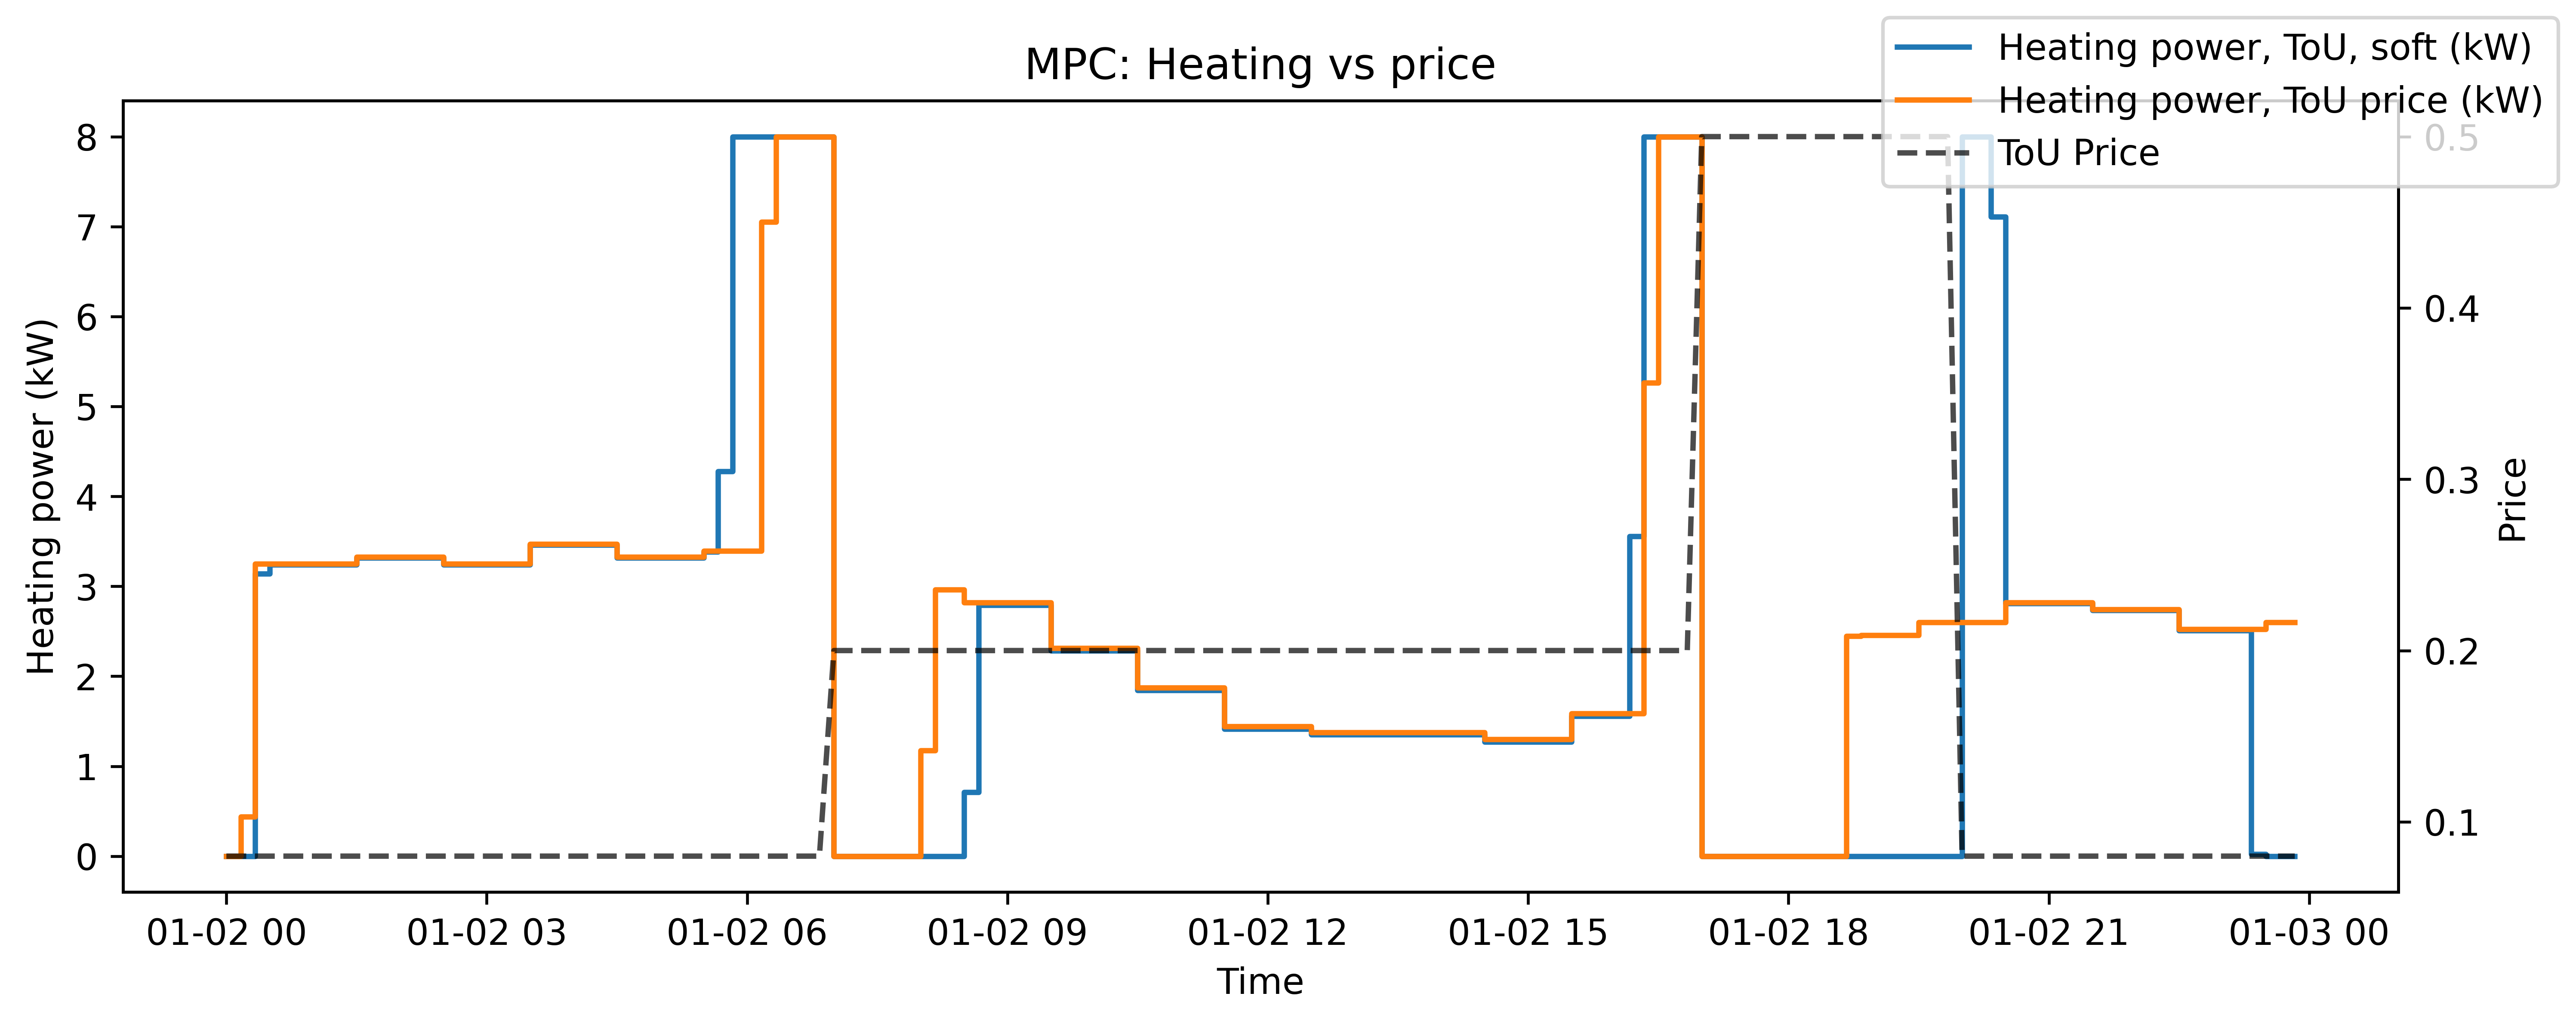

In [36]:
# MPC with soft constraints and slacks
lambda_slack = .01

T_tou_soft, u_tou_soft, _, _, _ = solve_mpc_rc_soft(T0, T_out[:N_steps], tou_price, alpha, gamma, T_min, T_max, 
                                      u_min, u_max, dt_minutes=10, lambda_slack = lambda_slack, verbose = 1)

# Note that optimal costs may not be comparable anymore


plt.figure(figsize=(10,4))
plt.plot(time_index, T_tou_soft[1:], label="Indoor temp (ToU, soft)")
plt.plot(time_index, T_tou[1:], label="Indoor temp (ToU)")
plt.axhline(T_min, color="grey", linestyle="--", label="Comfort band")
plt.axhline(T_max, color="grey", linestyle="--")
plt.ylabel("Temperature (°C)")
plt.xlabel("Time")
plt.legend()
plt.title(f"MPC: Indoor temperature trajectory, lambda = {lambda_slack}")
plt.tight_layout()
plt.show()


# Control and price
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.step(time_index, u_tou_soft, where="post", label="Heating power, ToU, soft (kW)")
ax1.step(time_index, u_tou, where="post", label="Heating power, ToU price (kW)")
ax1.set_ylabel("Heating power (kW)")
ax1.set_xlabel("Time")

ax2 = ax1.twinx()
ax2.plot(time_index, tou_price, "--", alpha=0.7, label="ToU Price", color = 'black')
# ax2.plot(time_index, fxd_price, "--", alpha=0.7, label="Fixed Price")
ax2.set_ylabel("Price")

fig.legend(loc="upper right")
plt.title("MPC: Heating vs price")
plt.tight_layout()
plt.show()

### Exercise

Add exercise for students:
- Find smallest $\lambda$ to recover the same solution as with hard constraints.
- What is the marginal value of relaxing the soft constraint? Examine how the objective value increases for a very small "discomfort".

# Dealing with Imperfect Models

So far, we assumed a perfect thermal dynamics model. Now let's explore what happens when we add noise and/or the parameters are biased.

### Process noise

Firstly, we consider process noise affecting the thermal dynamics model. 
The model is given by
\begin{aligned}
T_{k+1} = T_k + \alpha\bigl(T_{\text{out},k} - T_k\bigr)
+ \gamma u_k + \color{red}{w_k},
\end{aligned}
where $\color{red}{w_k}$ represents process noise that follows a normal distribution $\mathcal{N}(0, \sigma^2)$, where $\sigma$ is the standard deviation.

### Model misspecification

Secondly, we examine the case of model misspecification. Let us assume that model parameters $\alpha, \gamma$ are biased and the true parameters are given by $\alpha^{\text{true}} = 1.3 \alpha$ ("leakier" envelope) and $\gamma^{\text{true}} = 0.9 \gamma$ (slightly less efficient heating).

**ToDo**:
- Case one: process noise
- Case two: biased parameters
- Solve softMPC, discuss results
- Solve closed-loop softMPC, receding horizon approach
- Analyze what happens in the recending horizon approach (debiasing and wobbly to balance measurement noise)\

Open-loop solve status: optimal


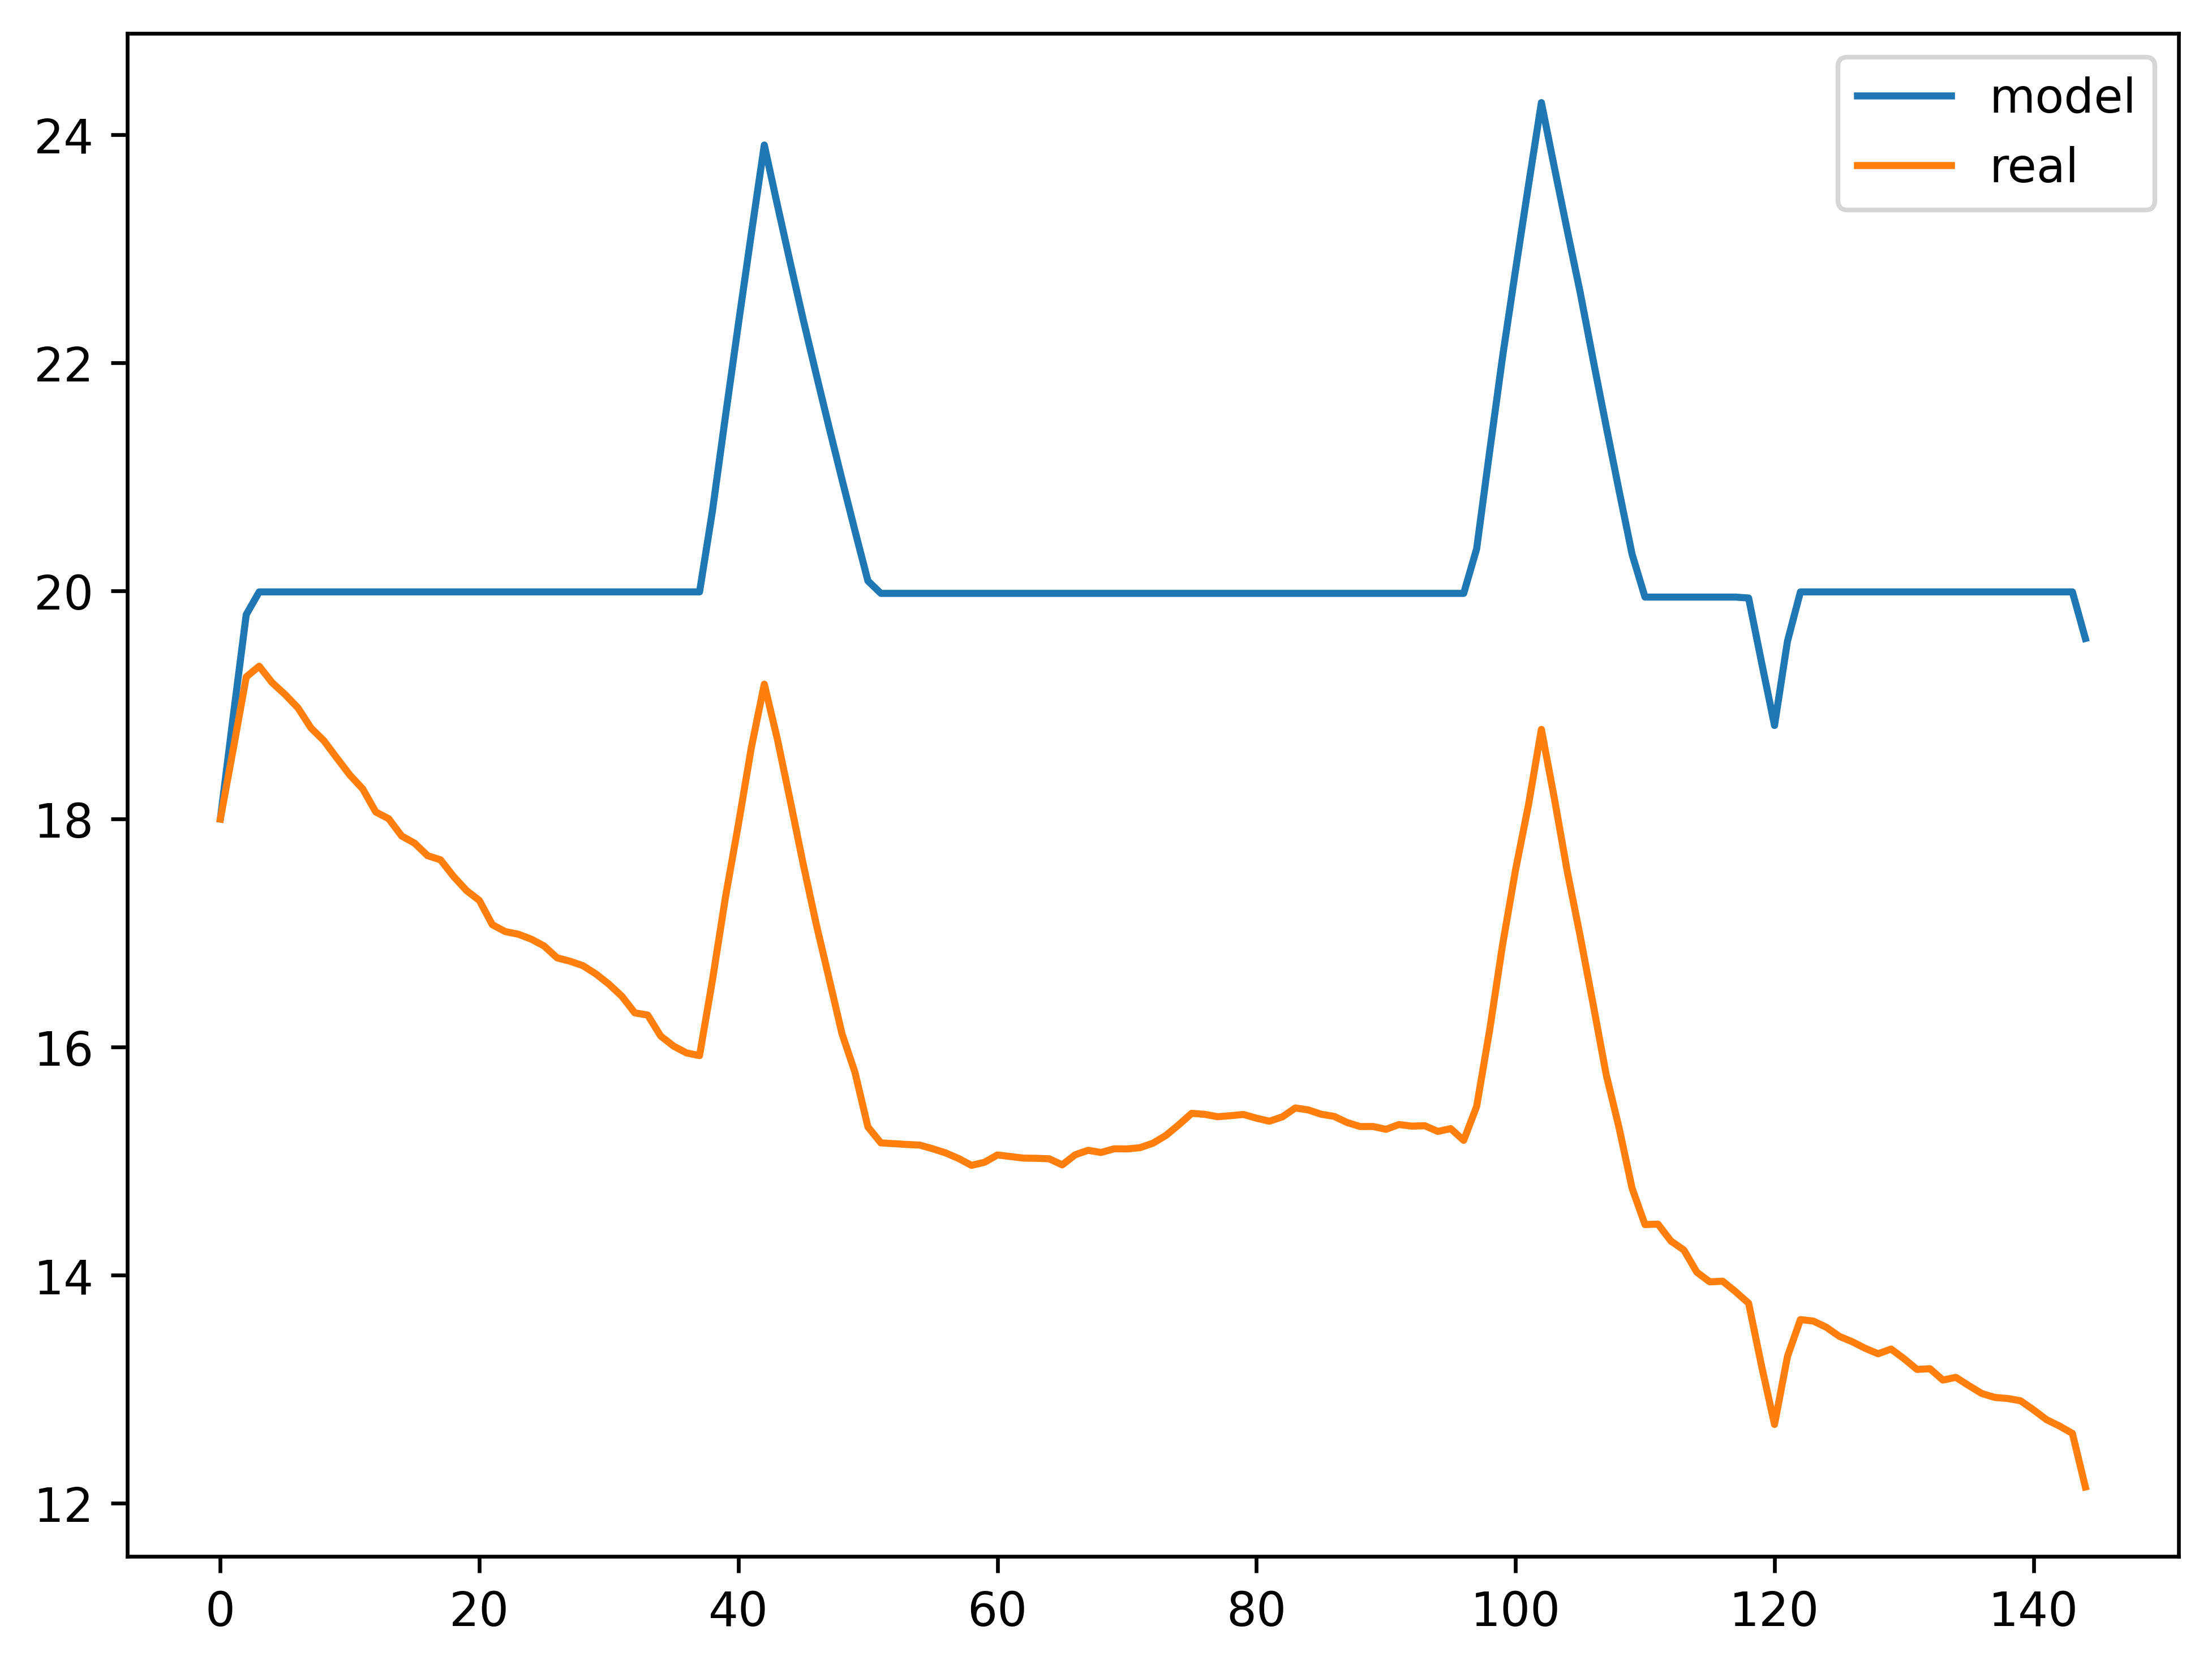

In [37]:
### What happens when we have noise

### Add some noise to the simulation 
def simulate_real_plant_step(T_real_k, T_out_k, u_k, alpha_p, gamma_p, process_noise_std=1, rng=123,):
    """
    One-step update of the 'real' plant:
      T_real_{k+1} = T_real_k + alpha_p*(T_out_k - T_real_k) + gamma_p*u_k + w_k

    w_k ~ N(0, process_noise_std^2) if std > 0.
    """
    if rng is None:
        rng = np.random.default_rng()
    w_k = rng.normal(0.0, process_noise_std) if process_noise_std > 0 else 0.0
    T_next = T_real_k + alpha_p * (T_out_k - T_real_k) + gamma_p * u_k + w_k
    return T_next


# Noise settings
process_noise_std = 0.05   # °C process noise (plant)
meas_noise_std    = 0.1    # °C measurement noise
rng = np.random.default_rng(123)

# --- SINGLE-SHOT / OPEN-LOOP MPC ---
lambda_slack = 0.1
T0_real = 18.0


dt_minutes = 10
alpha = 0.0208     # controller model
gamma = 0.16

# Real plant is a bit leakier and slightly less effective heating
alpha_p = alpha * 1.3    # more heat loss
gamma_p = gamma * 0.9    # heater slightly weaker

T_model_ol, u_ol, s_p_ol, s_m_ol, prob_ol = solve_mpc_rc_soft(T0=T0_real, T_out=T_out_MPC, price=tou_price,
    alpha=alpha, gamma=gamma,
    T_min=T_min, T_max=T_max,
    u_min=u_min, u_max=u_max,
    dt_minutes=dt_minutes, lambda_slack=lambda_slack,)

print("Open-loop solve status:", prob_ol.status)
#%%
# Simulate real plant with that open-loop control, including noise
T_real_ol = np.zeros(N_steps + 1)
T_real_ol[0] = T0_real
for k in range(N_steps):
    T_real_ol[k+1] = simulate_real_plant_step( T_real_ol[k], T_out_MPC[k],
        u_ol[k], alpha_p=alpha_p, gamma_p=gamma_p,
        process_noise_std=process_noise_std, rng=rng,)

plt.plot(T_model_ol, label = 'model')
plt.plot(T_real_ol, label = 'real')
plt.legend()
plt.show()

# Open-Loop vs Receding-Horizon MPC

So far, we solved the optimization problems once for the full predictive horizon and implement all decisions. 
We will now consider a true MPC framework by implementing a receding-horizon (closed-loop) solution.

### Open-loop MPC  
- Solve once at $(k=0)$.  
- Apply the entire sequence $(u_0, u_1, …, u_T)$ without re-optimizing.  
- Fails if model ≠ real world.

### Receding-Horizon MPC (True MPC)  
- At each step:
  1. Measure $(T_k)$ (with noise).  
  2. Solve MPC for horizon $H$.  
  3. Apply only $u_k$.  
  4. Advance to $k+1$.
  5. Re-optimize (go back to step 1).  
- Robust to model mismatch and noise.

Next cell implements a function for closed-loop MPC.

In [38]:
def receding_horizon_mpc(
    T0_real, T_out, price,
    alpha, gamma,
    alpha_p, gamma_p,
    T_min, T_max,
    u_min, u_max, dt_minutes=10, lambda_slack=10.0,
    H_steps=18,  # e.g. 3h @ 10min
    process_noise_std=0.0, meas_noise_std=0.0, rng=None, verbose = 0):
    """
    Receding horizon MPC with:
      - deterministic controller model (alpha, gamma),
      - real plant with (alpha_p, gamma_p) + process noise,
      - noisy measurements of T_real.
    """
    T_out = np.asarray(T_out)
    price = np.asarray(price)
    N = len(T_out)

    if rng is None:
        rng = np.random.default_rng()

    # Storage
    T_real = np.zeros(N + 1)
    T_meas = np.zeros(N + 1)
    u_applied = np.zeros(N)

    # Initial state
    T_real[0] = T0_real
    T_meas[0] = T0_real + rng.normal(0.0, meas_noise_std) if meas_noise_std > 0 else T0_real

    for k in range(N):
        # Build horizon window [k, k+H)
        k_end = min(k + H_steps, N)
        T_out_win = T_out[k:k_end]
        price_win = price[k:k_end]

        # Use current measured temp as initial state for MPC
        T0_mpc = float(T_meas[k])

        # Solve MPC on this window
        T_opt, u_opt, _, _, prob = solve_mpc_rc_soft(
            T0=T0_mpc,
            T_out=T_out_win,
            price=price_win,
            alpha=alpha,
            gamma=gamma,
            T_min=T_min,
            T_max=T_max,
            u_min=u_min,
            u_max=u_max,dt_minutes=dt_minutes,lambda_slack=lambda_slack, verbose = verbose)

        if prob.status not in ["optimal", "optimal_inaccurate"]:
            print(f"Warning: MPC infeasible at step {k}, status={prob.status}")
            u_k = 0.0
        else:
            u_k = float(u_opt[0])  # apply only first control move

        u_applied[k] = u_k

        # Update real plant
        T_real[k+1] = simulate_real_plant_step(
            T_real[k],
            T_out[k],
            u_k,
            alpha_p=alpha_p,
            gamma_p=gamma_p,
            process_noise_std=process_noise_std,
            rng=rng,
        )

        # New measurement
        T_meas[k+1] = T_real[k+1] + (
            rng.normal(0.0, meas_noise_std) if meas_noise_std > 0 else 0.0
        )

    return T_real, T_meas, u_applied

Let's examine how the closed-loop MPC performs in this setting.

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_10868\598210250.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


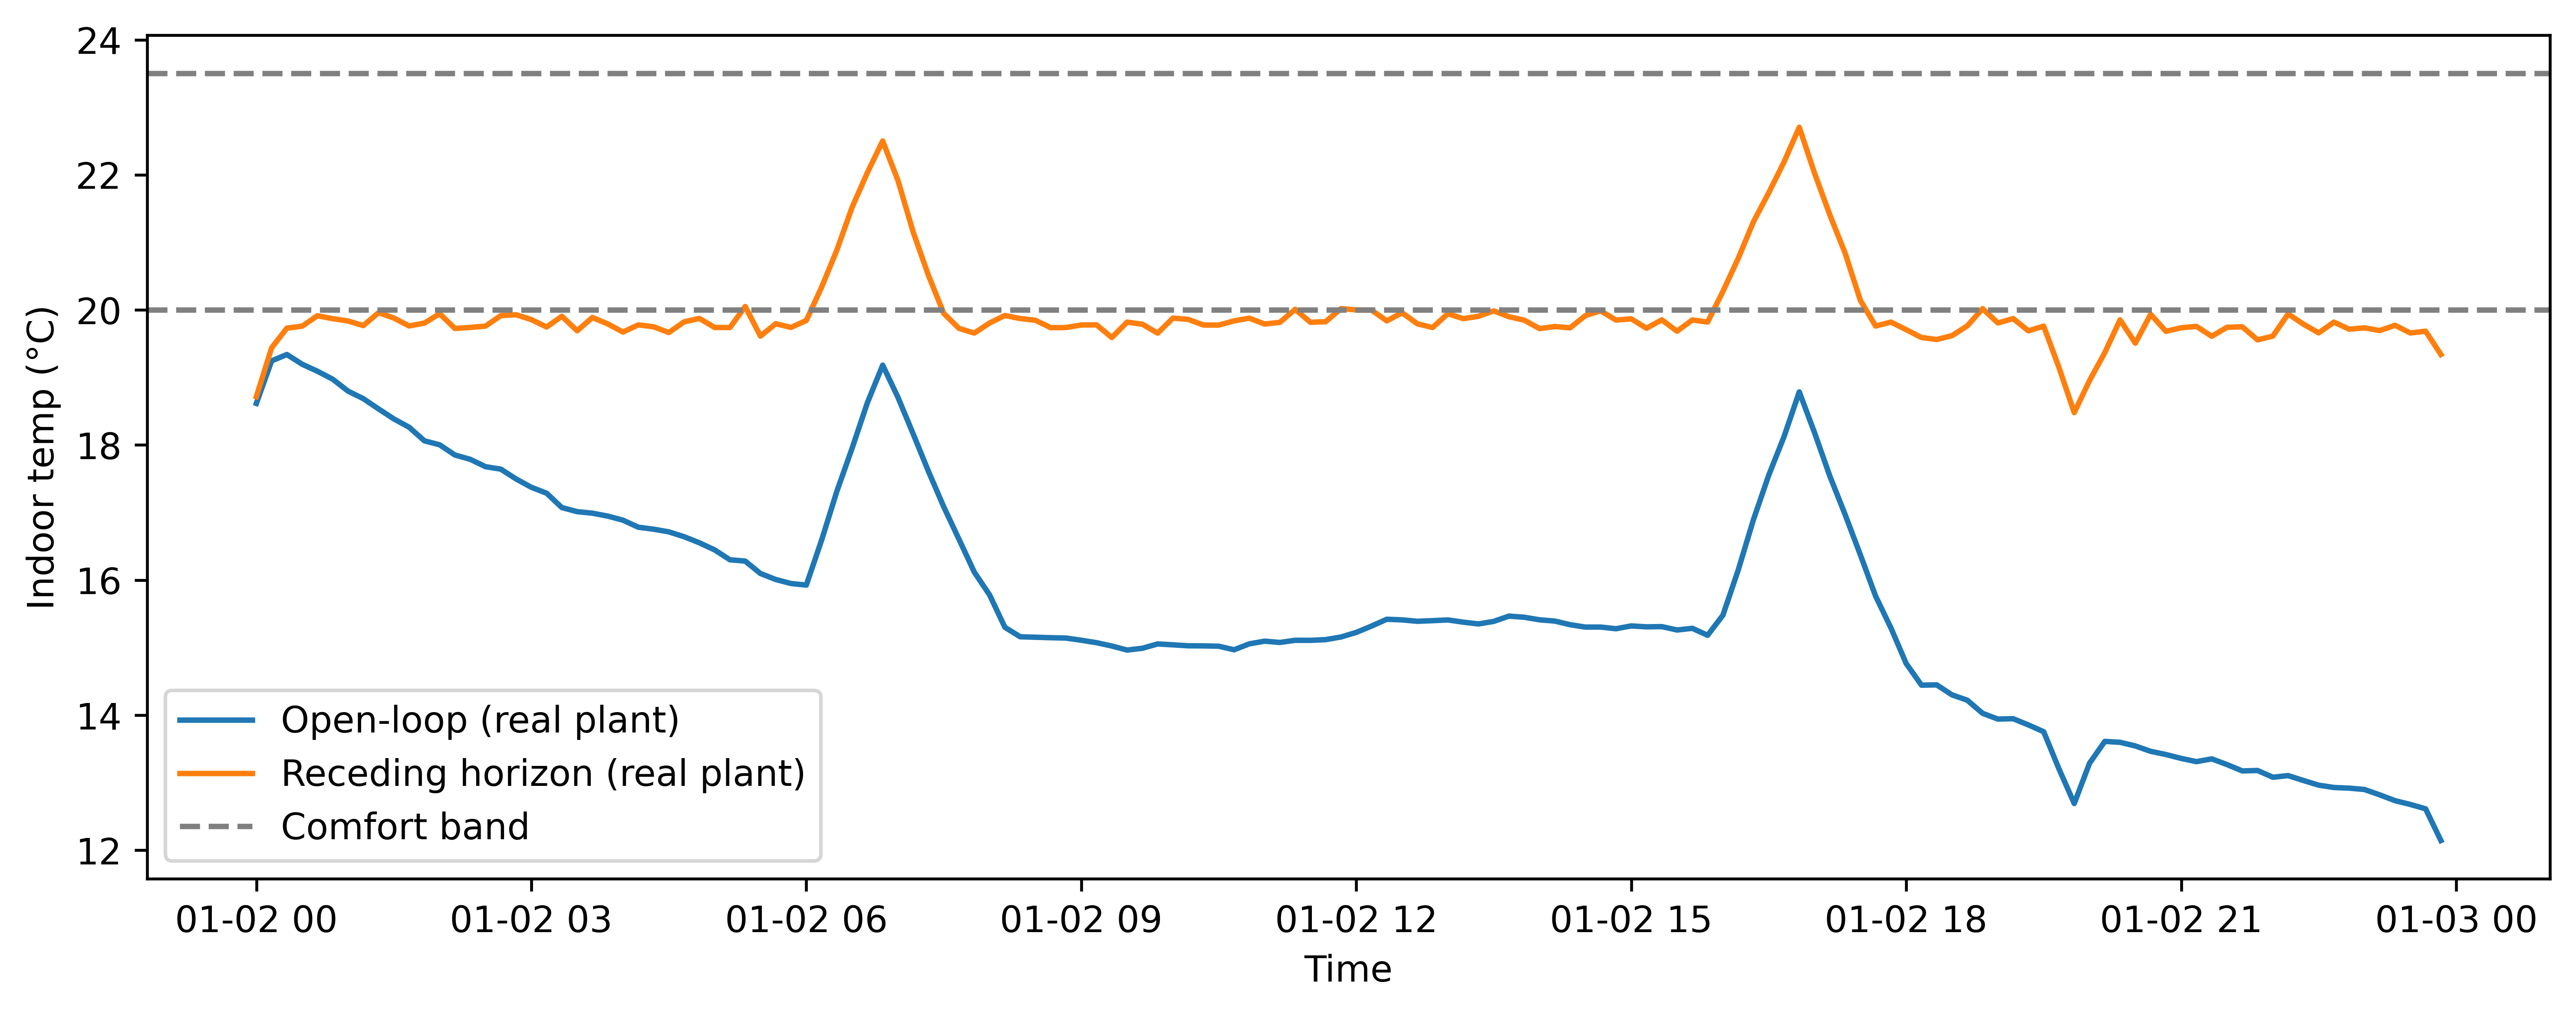

C:\Users\ucbva19\AppData\Local\Temp\ipykernel_10868\598210250.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


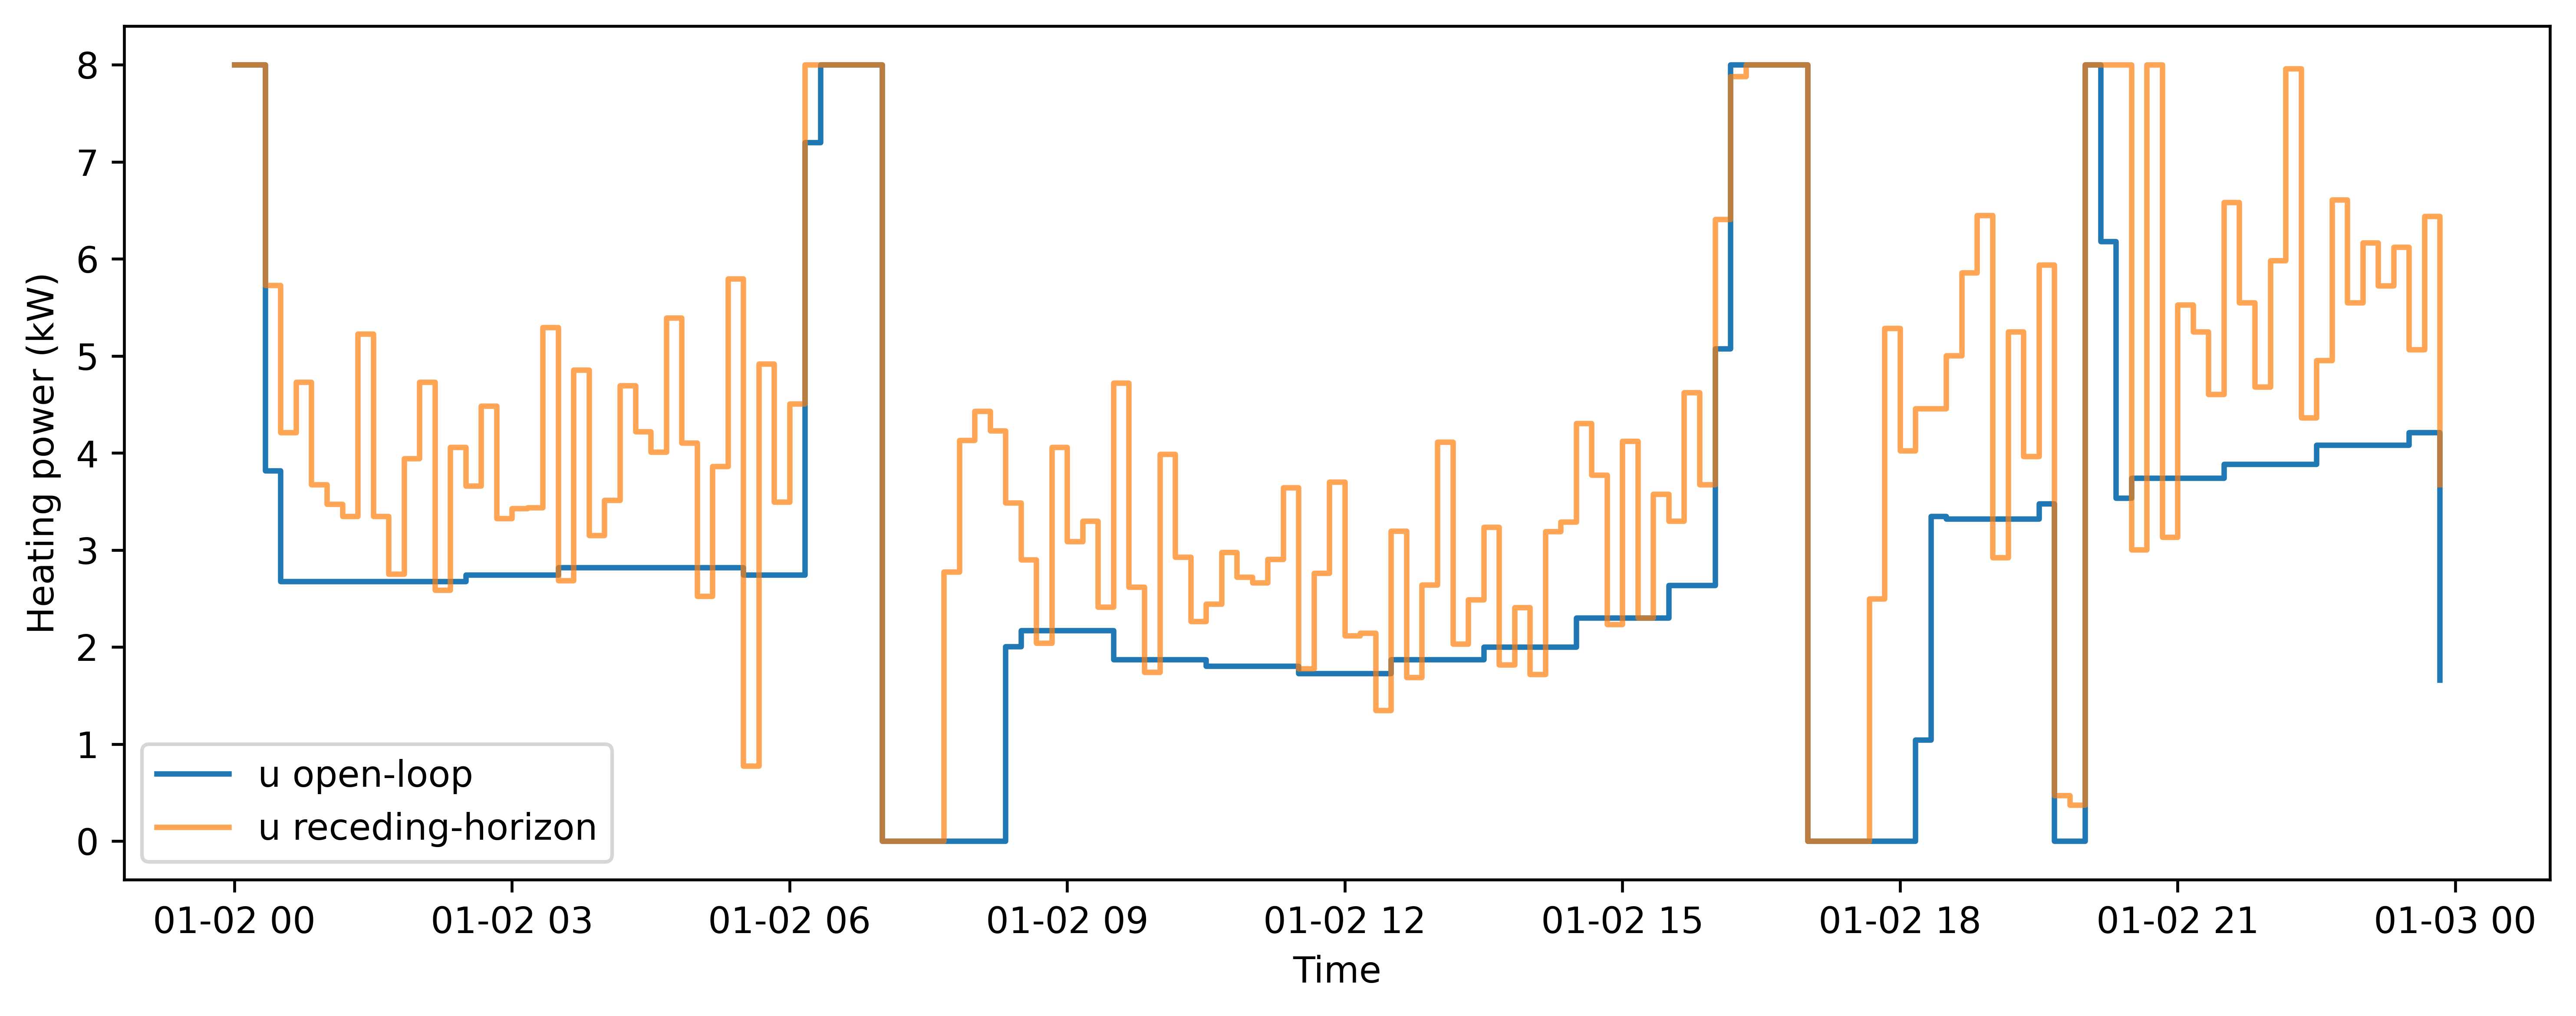

In [39]:
H_steps = 18  # 3 hours @ 10-min
T_real_rh, T_meas_rh, u_rh = receding_horizon_mpc(
    T0_real=T0_real, T_out=T_out_MPC, price=tou_price,
    alpha=alpha, gamma=gamma, alpha_p=alpha_p, gamma_p=gamma_p,
    T_min=T_min, T_max=T_max, u_min=u_min, u_max=u_max,
    dt_minutes=dt_minutes, lambda_slack=lambda_slack, H_steps=H_steps, process_noise_std=process_noise_std, meas_noise_std=meas_noise_std, rng= rng)

#%%

# Temperature trajectories
plt.figure(figsize=(10,4))
plt.plot(time_index, T_real_ol[1:], label="Open-loop (real plant)")
plt.plot(time_index, T_real_rh[1:], label="Receding horizon (real plant)")
plt.axhline(T_min, color="grey", linestyle="--", label="Comfort band")
plt.axhline(T_max, color="grey", linestyle="--")
plt.ylabel("Indoor temp (°C)")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

# Inputs
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.step(time_index, u_ol, where="post", label="u open-loop")
ax1.step(time_index, u_rh, where="post", label="u receding-horizon", alpha=0.7)
ax1.set_ylabel("Heating power (kW)")
ax1.set_xlabel("Time")
ax1.legend()
plt.tight_layout()
plt.show()


**Discussion points**:
- How does closed-loop correct errors?
- Why we have wobly control actions? $\rightarrow$ correcting measurement noise
- Highlight offset (average power) $\rightarrow$ correction to biased parameters
- Run these examples separately to illustrate the effect.

**ToDo**
- (optional) add simple rule-based control policy
- Summarize what we learned in module

# Closed-Loop Thermostat Baseline

A simple baseline controller:  
- If $(T_k < T_\text{set} - d/2)$: heat at full power.  
- If $(T_k > T_\text{set} + d/2)$: turn heating off.  
- Else: maintain previous action.

This is typical of residential thermostats.  
ToDo: compare MPC to this baseline.

---

# 🎯 Summary of What You Will Learn

- How to convert a **physical RC model** into a **discrete-time model**.  
- How to formulate **MPC with soft comfort constraints**.  
- Why **open-loop MPC fails** under model mismatch.  
- Why **receding-horizon MPC** is robust.  
- How MPC compares to a classical **thermostat controller**.

---
